# MagPySV example workflow - European observatories

# Setup

In [1]:
# Setup python paths and import some modules
from IPython.display import Image
import sys
sys.path.append('..')
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Import all of the MagPySV modules
import magpysv.denoise as denoise
import magpysv.inputoutput as inputoutput
import magpysv.model_prediction as model_prediction
import magpysv.svplots as svplots
import magpysv.svtools as svtools
import magpysv.misc as misc

In [2]:
%matplotlib notebook

# Downloading data

In [ ]:
from lib import consume_webservices as cws

wdc_app_path = '/Users/gracecox/geomag_wdc_web_app_interface/'
sys.path.append(wdc_app_path)
cadence = 'hour'

start_date = dt.date(1960, 1, 1)
end_date = dt.date(2009, 12, 31)
service = 'WDC'
download_dir = '/Users/gracecox/Desktop/download_test/'
configpath = os.path.join(wdc_app_path, 'lib/consume_rest.ini')

observatory_list = ['CLF', 'NGK', 'WNG']

[
cws.fetch_data(
        start_date, end_date,
        observatory_, cadence,
        service, download_dir, configpath
)
for observatory_ in observatory_list]

In [3]:
observatory_list = ['CLF', 'NGK', 'WNG']
download_dir = '/Users/gracecox/Desktop/download_test/'

# Initial processing

Extract all data from the WDC files, convert into the proper hourly means using the tabular base and save the X, Y and Z components to CSV files.

In [ ]:
inputoutput.wdc_to_hourly_csv(wdc_path=download_dir, write_path=download_dir + '/hourly/', obs_list=observatory_list,
                  print_obs=True)

In [4]:
# Path to file containing baseline discontinuity information
baseline_data = misc.get_baseline_info(file_path='/Users/gracecox/Desktop/jumps_info/jump_records')

In [ ]:
# Loop over all observatories and calculate SV series for each
for observatory in observatory_list:
    print(observatory)
    # Load hourly data
    data_file = observatory + '.csv'
    hourly_data = inputoutput.read_csv_data(
        fname=os.path.join(download_dir + 'hourly/', data_file),
        data_type='mf')
    # Resample to monthly means
    resampled_field_data = svtools.data_resampling(hourly_data, sampling='MS', average_date=True)
    # Correct documented baseline changes
    misc.correct_baseline_change(observatory=observatory,
                          field_data=resampled_field_data,
                          jump_data=jump_data)
    # Write out the monthly means for magnetic field
    inputoutput.write_csv_data(data=resampled_field_data,
                            write_path=download_dir + 'monthly_mf/',
                            obs_name=observatory)
    # Calculate SV from monthly field means
    sv_data = svtools.calculate_sv(resampled_field_data,
                                   mean_spacing=1)
    # Write out the SV data
    inputoutput.write_csv_data(data=sv_data,
                               write_path=download_dir + 'monthly_sv/fdmm/',
                               obs_name=observatory)

# Field model predictions

We need some secular variation predictions from a geomagnetic field model. This example uses COV-OBS. The following code obtains the complete list of geomagnetic observatory locations from the WDC website, converts the lat/lon in degrees to colat/lon in radians and altitude from m to km, and then runs the COV-OBS model for each location to produce files containing the model prediction of SV and MF at that location.

In [ ]:
stations = model_prediction.get_observatory_list()

In [ ]:
model_prediction.run_covobs(stations=stations, model_path='/Users/gracecox/Dropbox/cov-obs_x1/',
                            output_path='/Users/gracecox/Dropbox/cov-obs_x1/monthly_vals/')

# Residuals

Concatenate the data for our selected observatories.

In [5]:
# Start and end dates of the analysis as (year, month, day)
start = dt.datetime(1960, 1, 1)
end = dt.datetime(2010, 12, 31)

obs_data, model_sv_data, model_mf_data = inputoutput.combine_csv_data(
    start_date=start, end_date=end, obs_list=observatory_list,
    data_path=download_dir + 'monthly_sv/fdmm/',
    model_path="/Users/gracecox/Dropbox/field_models/cov-obs_x1/monthly_vals/", day_of_month=1)

dates = obs_data['date']

In [6]:
obs_data

date      dX_CLF      dY_CLF      dZ_CLF      dX_NGK      dY_NGK  \
0   1960-01-01         NaN         NaN         NaN  122.725806  -21.161290   
1   1960-02-01   65.857054   11.285656  -68.338710   65.166852    1.989989   
2   1960-03-01    9.366719   29.104913   20.419355   19.123471   19.784205   
3   1960-04-01 -238.778123  140.757647  240.330645 -247.859677  140.687634   
4   1960-05-01  249.684424  -33.467349   24.733871  206.924194  -46.026344   
5   1960-06-01  149.222754   -0.667829  -95.683871  108.625806   -6.606989   
6   1960-07-01  -30.420701   37.405622   43.312903  -34.174194   27.042473   
7   1960-08-01   -5.419662   15.926947  -14.580645  -13.129032    3.306452   
8   1960-09-01  -78.309808   97.761501   -4.365591  -86.280108   74.217742   
9   1960-10-01 -175.948111   82.823276  110.559140 -153.832796   81.830645   
10  1960-11-01   43.045288   42.496361   40.907527   27.466129   20.519355   
11  1960-12-01  139.313268  -11.416351   23.495699  112.711290  -19.180645   
12  1961-01-01  203.177830  -14.414765  -67.919355  162.467742  -23.403226   
13  1961-02-01   11.833071   55.313299   14.701037  -16.361175   35.858871   
14  1961-03-01  120.776223  -12.364994  -83.023618   89.603111  -29.552419   
15  1961-04-01   62.409919   45.806548    7.762903   51.495699   34.344086   
16  1961-05-01  120.055822   12.929569  -58.343548   94.697849   21.204301   
17  1961-06-01    7.728047   29.707177    9.443548   15.452151   34.879032   
18  1961-07-01 -140.902651   79.960974   68.104839 -133.436022   62.798387   
19  1961-08-01  116.977173  -21.288639  -18.419355  102.806452  -36.080645   
20  1961-09-01   14.525904   44.183394  -40.185484  -11.303763   37.315591   
21  1961-10-01 -105.333271   85.793048   64.362903 -131.357527   78.942473   
22  1961-11-01   73.030544   22.959705  119.570430   82.624194    8.290860   
23  1961-12-01   62.590518   33.481870   37.961828   38.746774    0.434946   
24  1962-01-01  104.990724    7.901872  -10.112903   88.306452   -9.451613   
25  1962-02-01    6.191229   35.067692 -128.532258   28.096774   16.142857   
26  1962-03-01  104.963767   23.021724  -33.870968   72.274194    1.873272   
27  1962-04-01   -3.142856   58.848612   29.220968  -16.207527   41.750538   
28  1962-05-01  116.368194   -3.534043  -35.527419   99.062366   -2.815054   
29  1962-06-01   15.249212   24.500224   34.060753   17.837634   17.481720   
..         ...         ...         ...         ...         ...         ...   
582 2008-07-01   15.312366   39.510753   31.152151    9.539247   41.610753   
583 2008-08-01   -0.790323   50.016129   -2.161290  -21.338710   33.741935   
584 2008-09-01    0.111290   53.339785   20.892473  -19.717204   51.030645   
585 2008-10-01  -18.820968   51.289247   40.494624  -23.766667   41.808065   
586 2008-11-01   57.544125   45.173247    4.944412   49.283333   39.708602   
587 2008-12-01   26.633294   47.810624   27.007201   17.555376   48.920430   
588 2009-01-01   22.629032   54.677419   20.919355    6.838710   48.290323   
589 2009-02-01   31.939516   44.087558   -1.282258   14.786866   34.233295   
590 2009-03-01   44.834677   47.396313   -6.169355   31.906682   40.331221   
591 2009-04-01   38.923656   39.198925   -5.247312   37.429032   38.091398   
592 2009-05-01   35.898925   68.704301   15.860215   15.329032   50.086022   
593 2009-06-01   23.334409   49.845699   40.789785   21.470968   52.580645   
594 2009-07-01  -56.592473   70.638172   45.823118  -57.793548   56.322581   
595 2009-08-01    2.693548   53.145161   25.758065   -6.790323   50.306452   
596 2009-09-01   28.532258   38.183333   -4.647849    1.333871   34.820968   
597 2009-10-01   -1.774194   65.994086   11.325269  -16.850000   59.404839   
598 2009-11-01   12.390860   49.455914   44.824731   10.616667   45.645161   
599 2009-12-01   47.786559   45.947312   10.707527   38.851075   34.887097   
600 2010-01-01         NaN         NaN         NaN  -17.467742   65.177419   
601 2010-02-01         NaN      

# SV plots

<IPython.core.display.Javascript object>


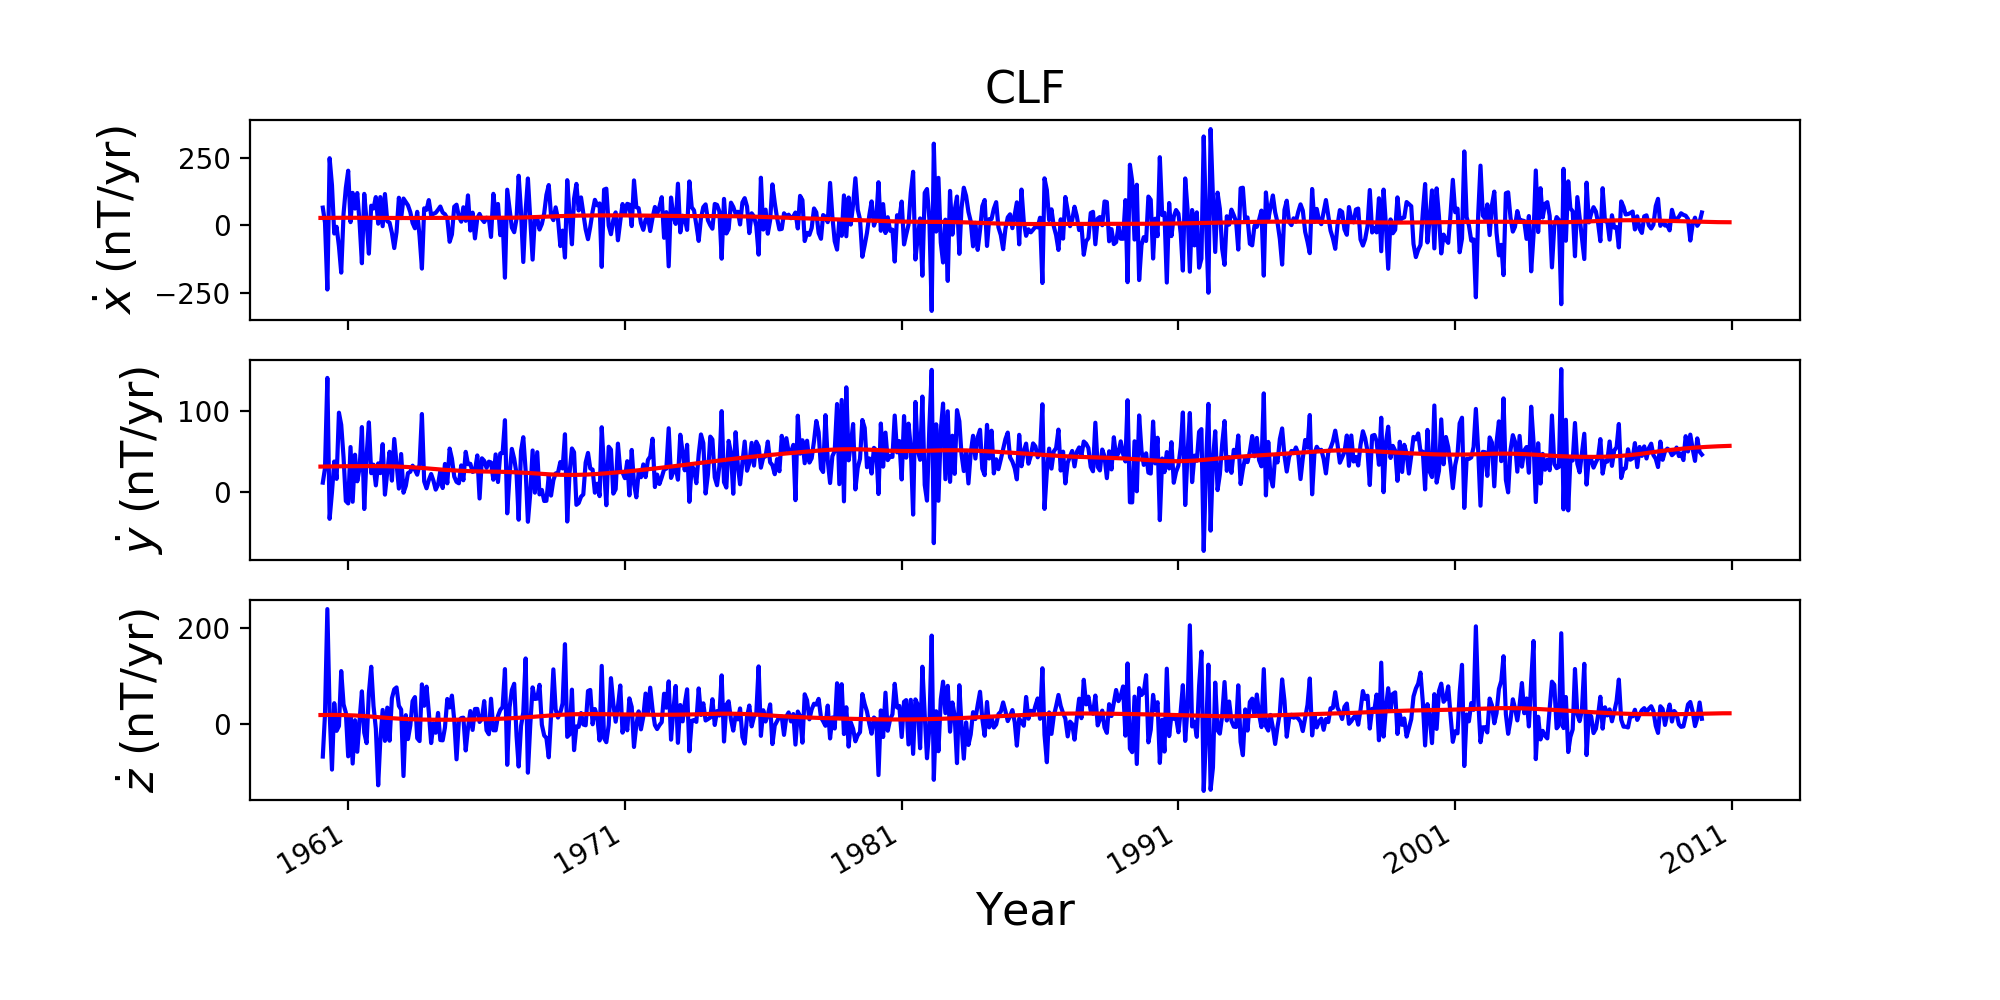

<IPython.core.display.Javascript object>


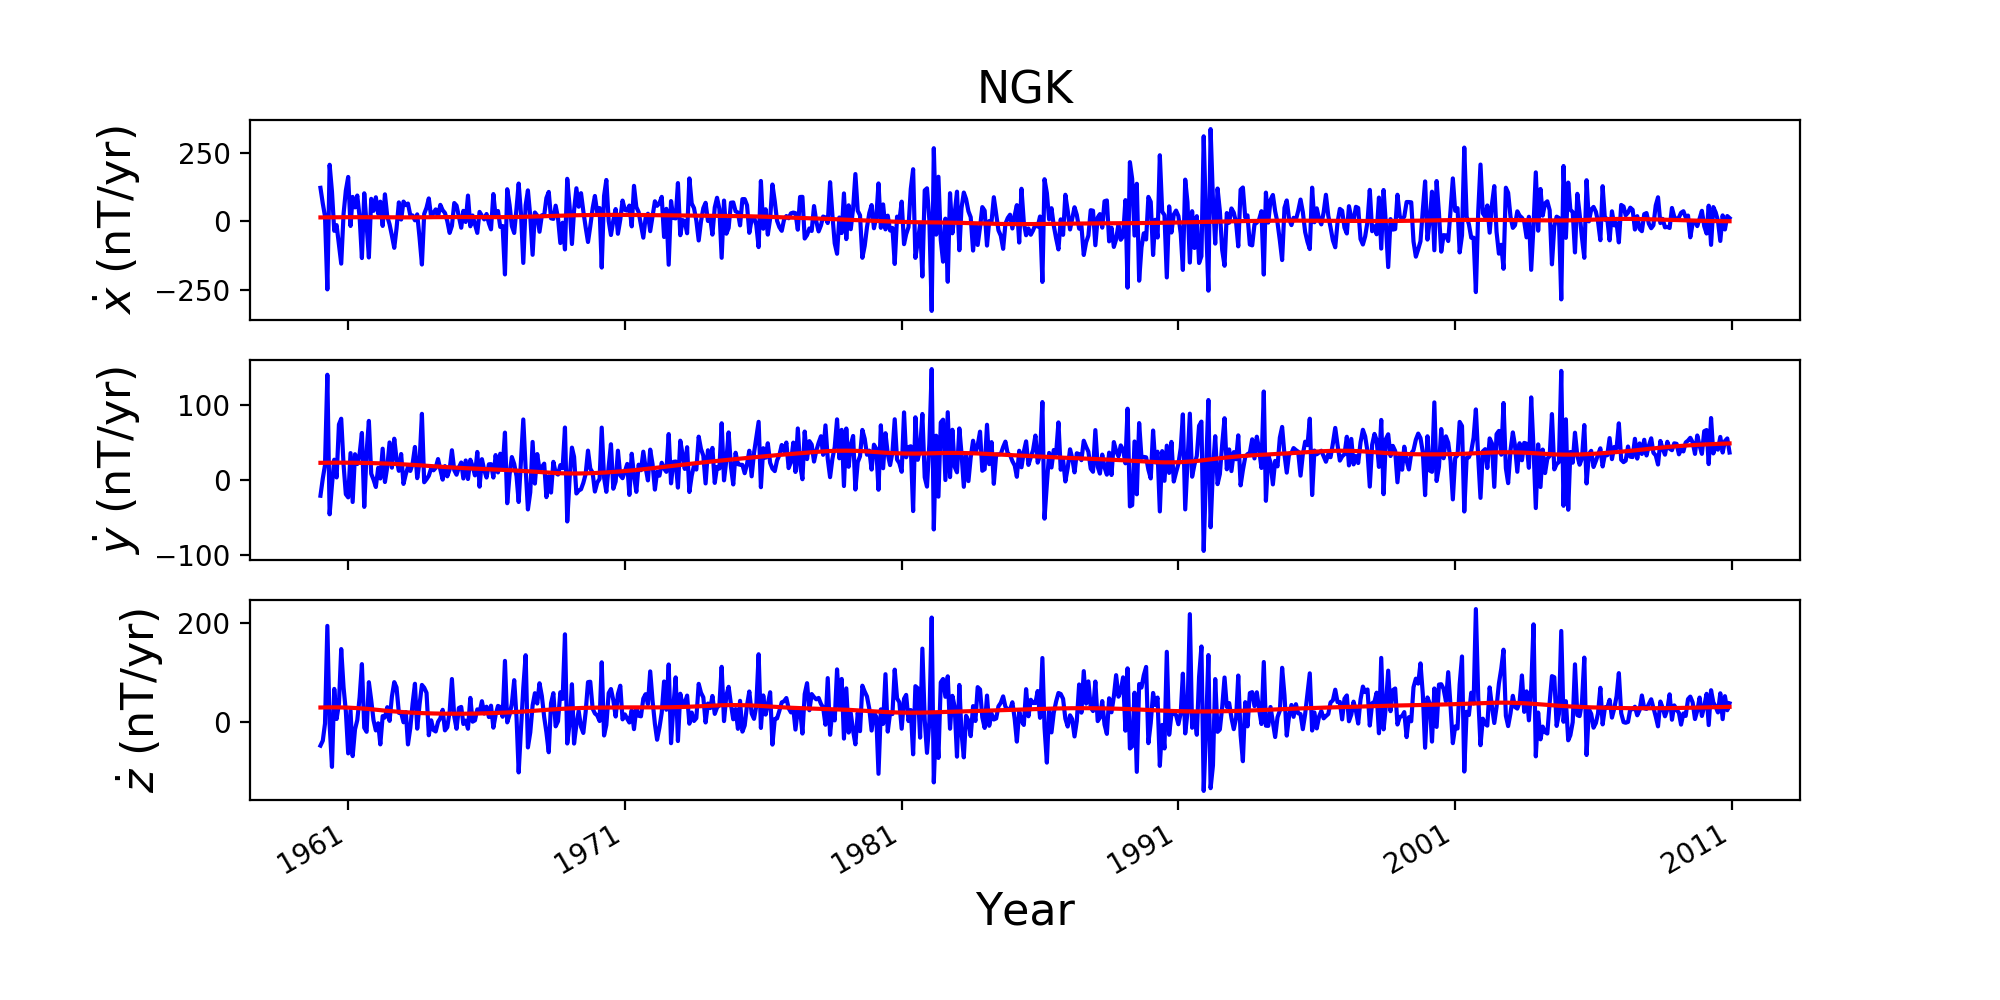

<IPython.core.display.Javascript object>


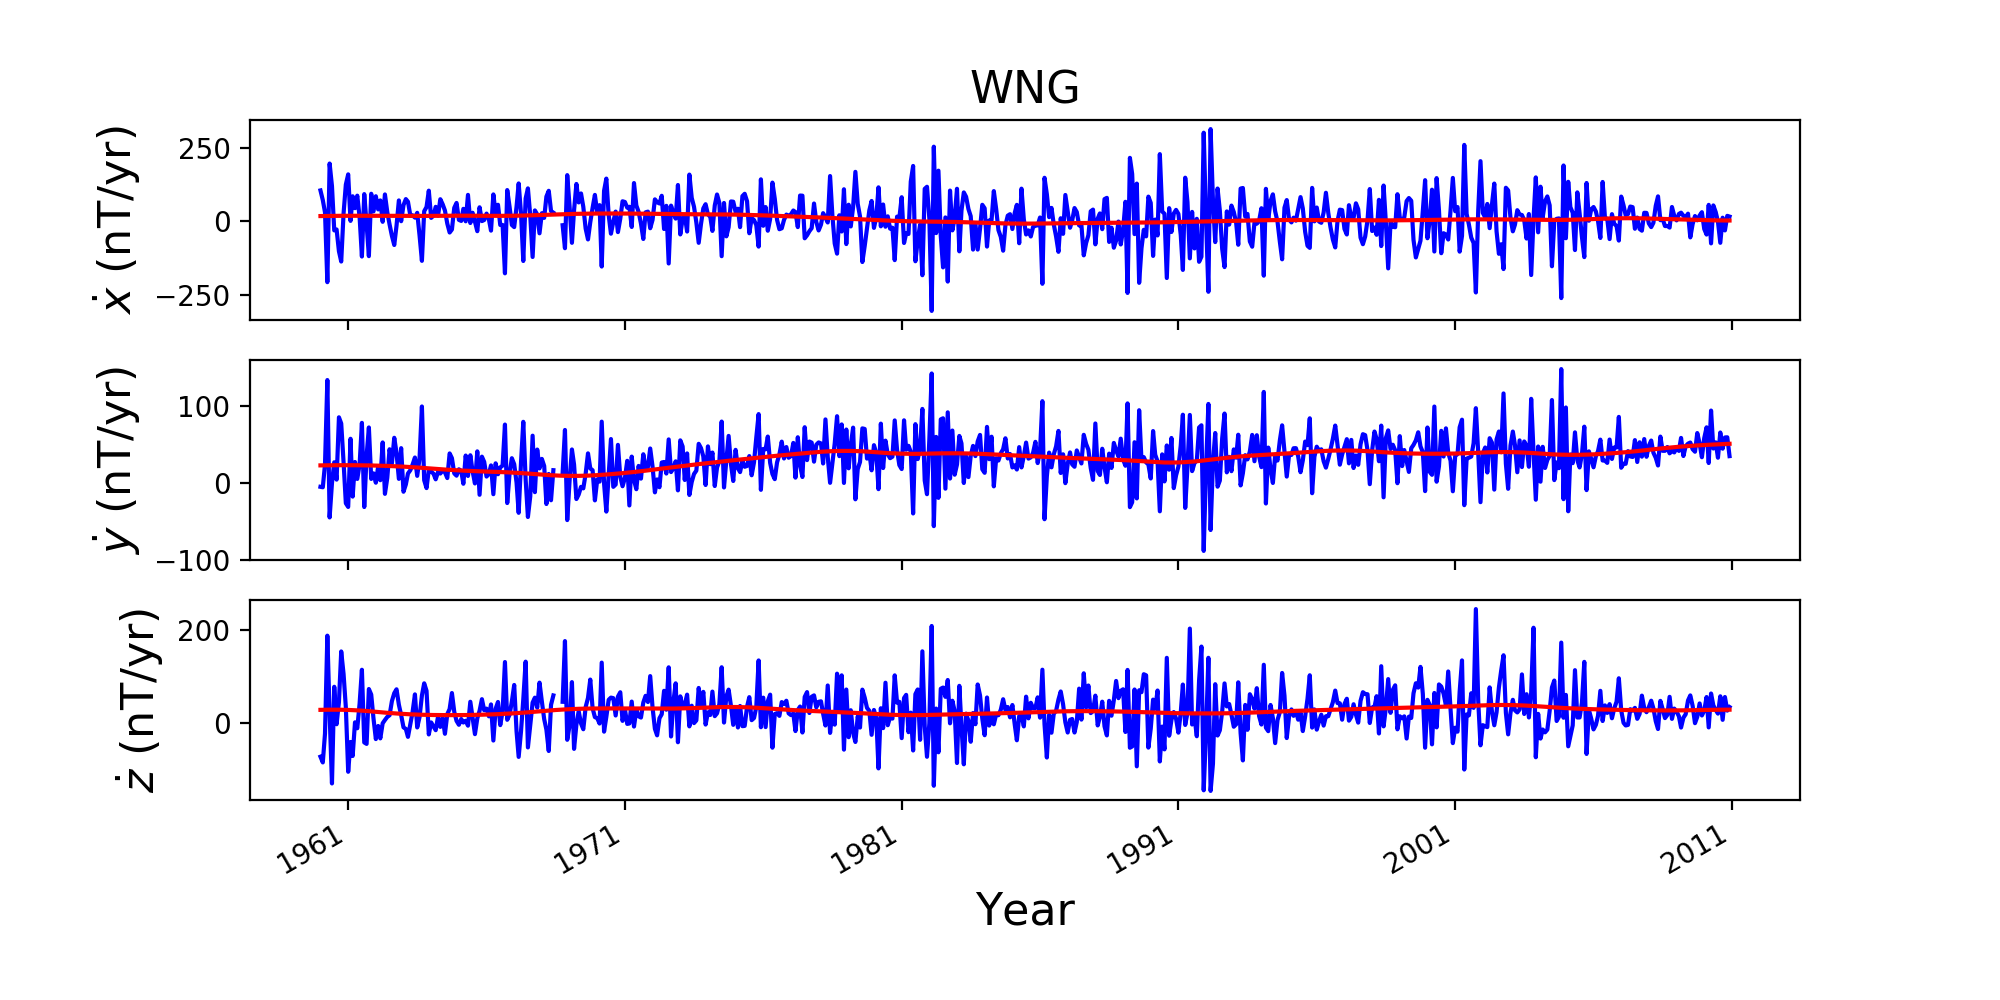

In [7]:
for observatory in observatory_list:
    fig = svplots.plot_sv(dates=dates, sv=obs_data.filter(regex=observatory),
                    model=model_sv_data.filter(regex=observatory),
                    fig_size=(10, 5), font_size=10, label_size=16, plot_legend=False,
                    obs=observatory, model_name='COV-OBS')

# Outlier detection

Optionally remove spikes in the data before denoising. Large outliers can affect the denoising process so better to remove them beforehand for some series (i.e. at high latitude observatories).

<IPython.core.display.Javascript object>


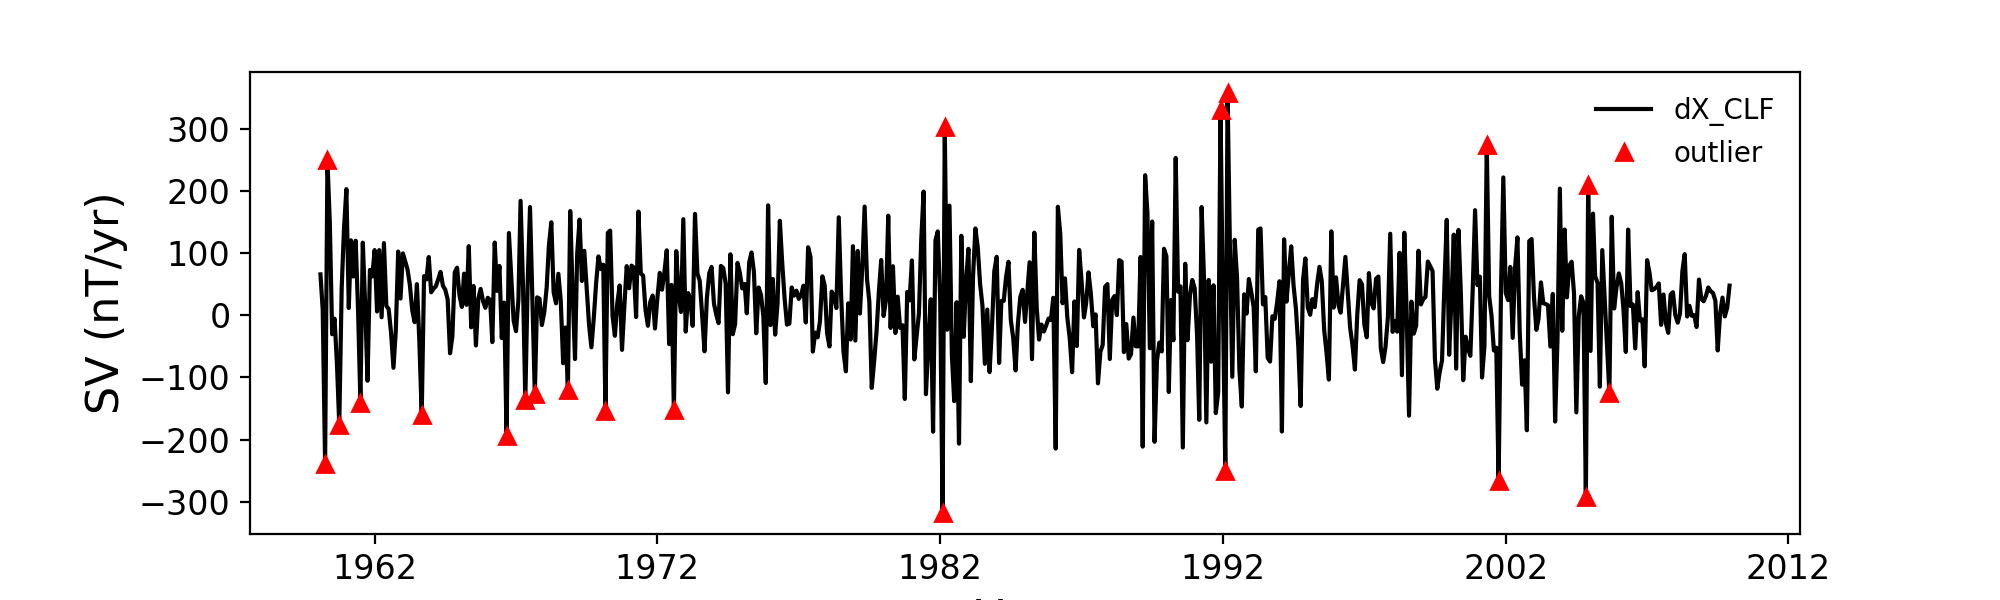

<IPython.core.display.Javascript object>


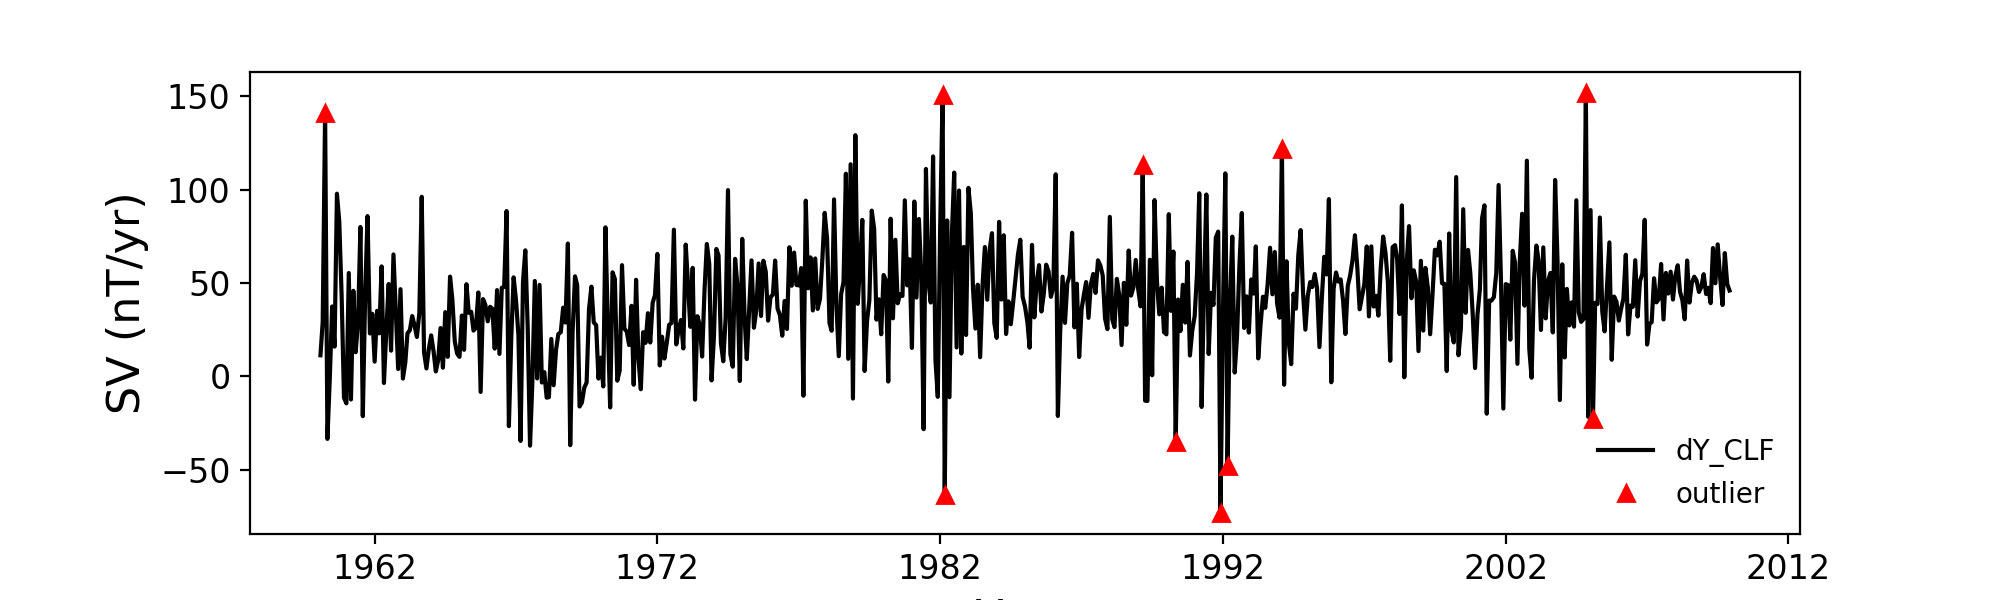

<IPython.core.display.Javascript object>


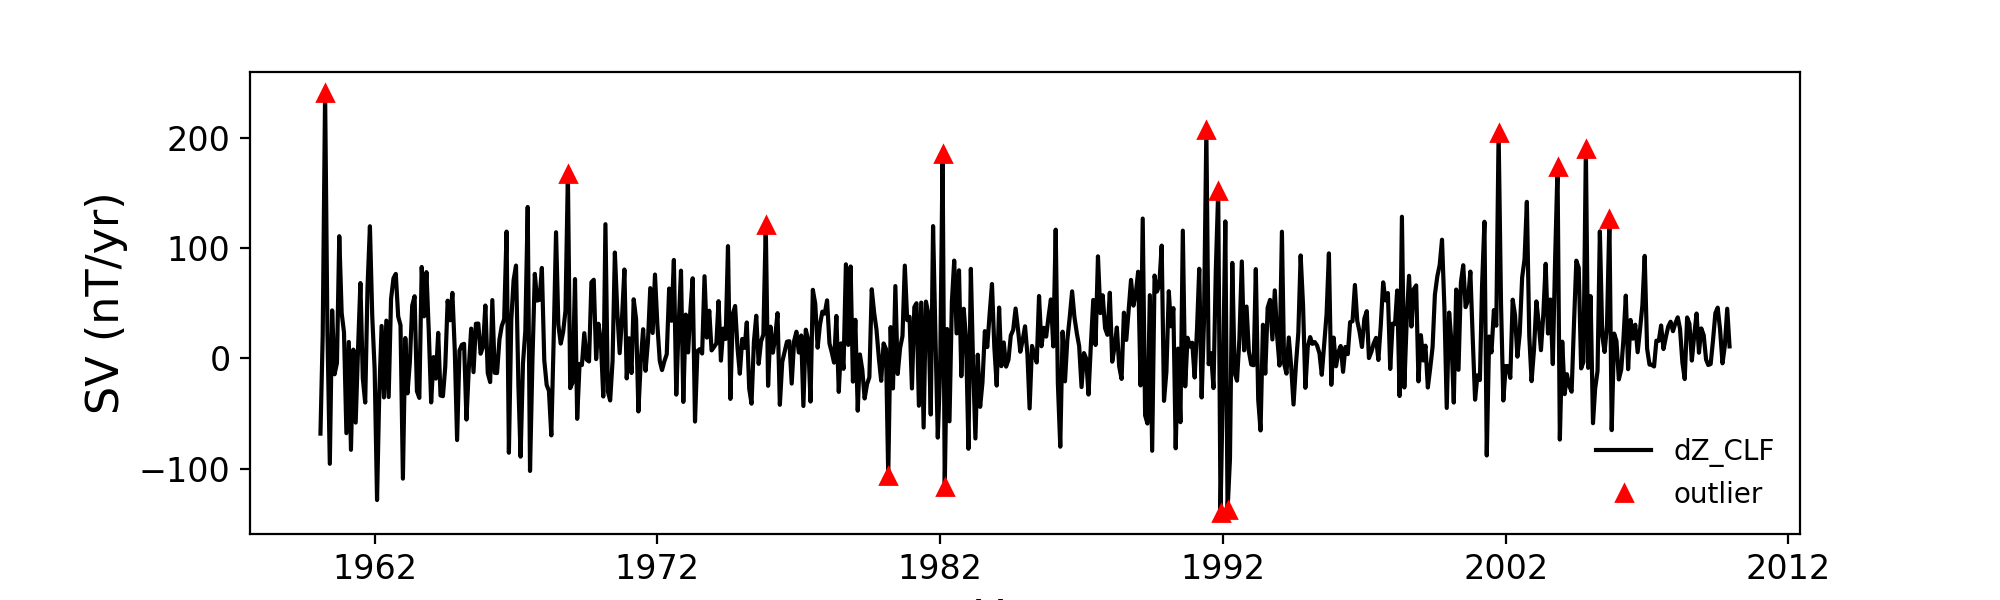

<IPython.core.display.Javascript object>


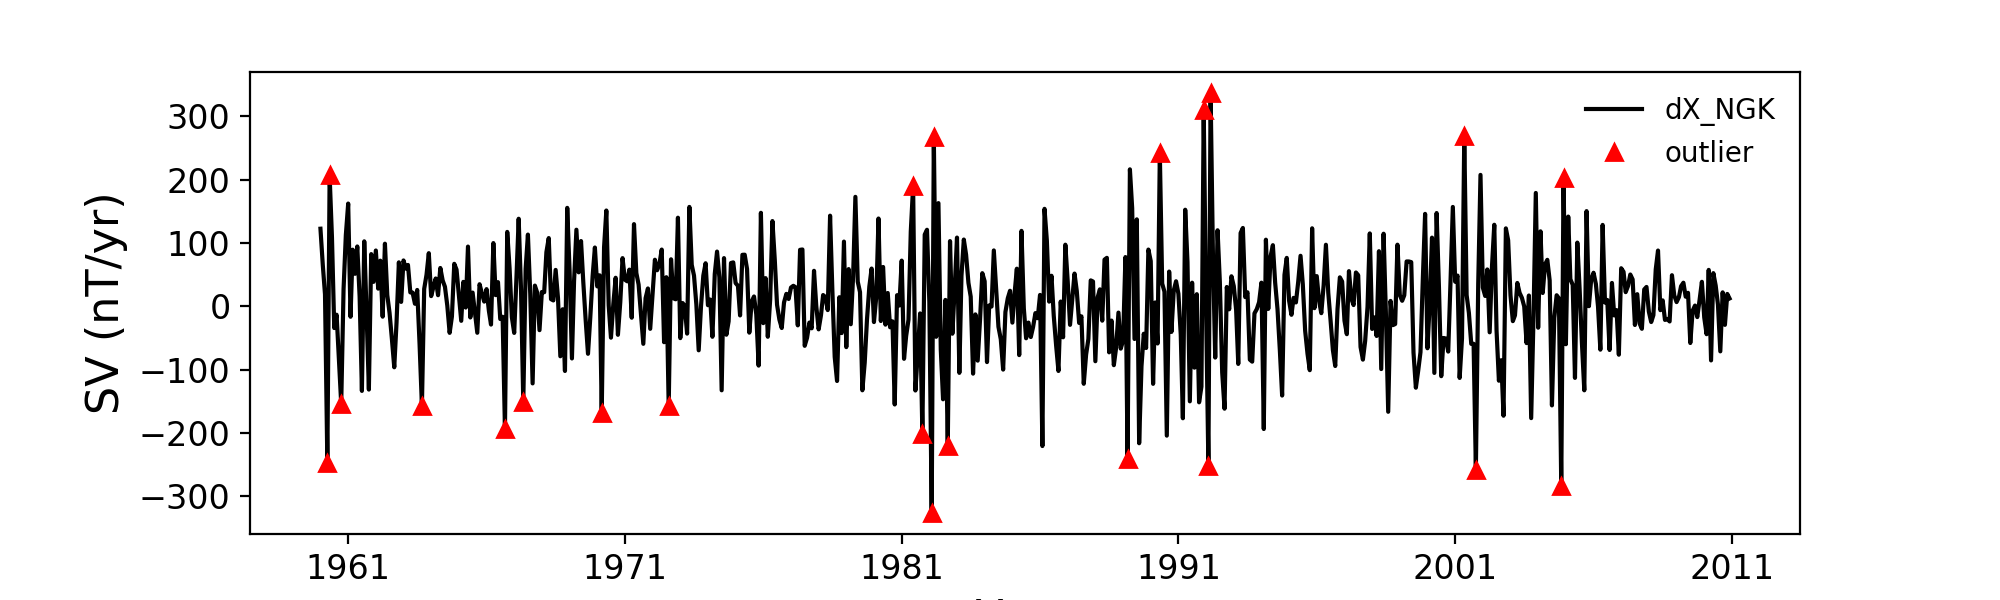

<IPython.core.display.Javascript object>


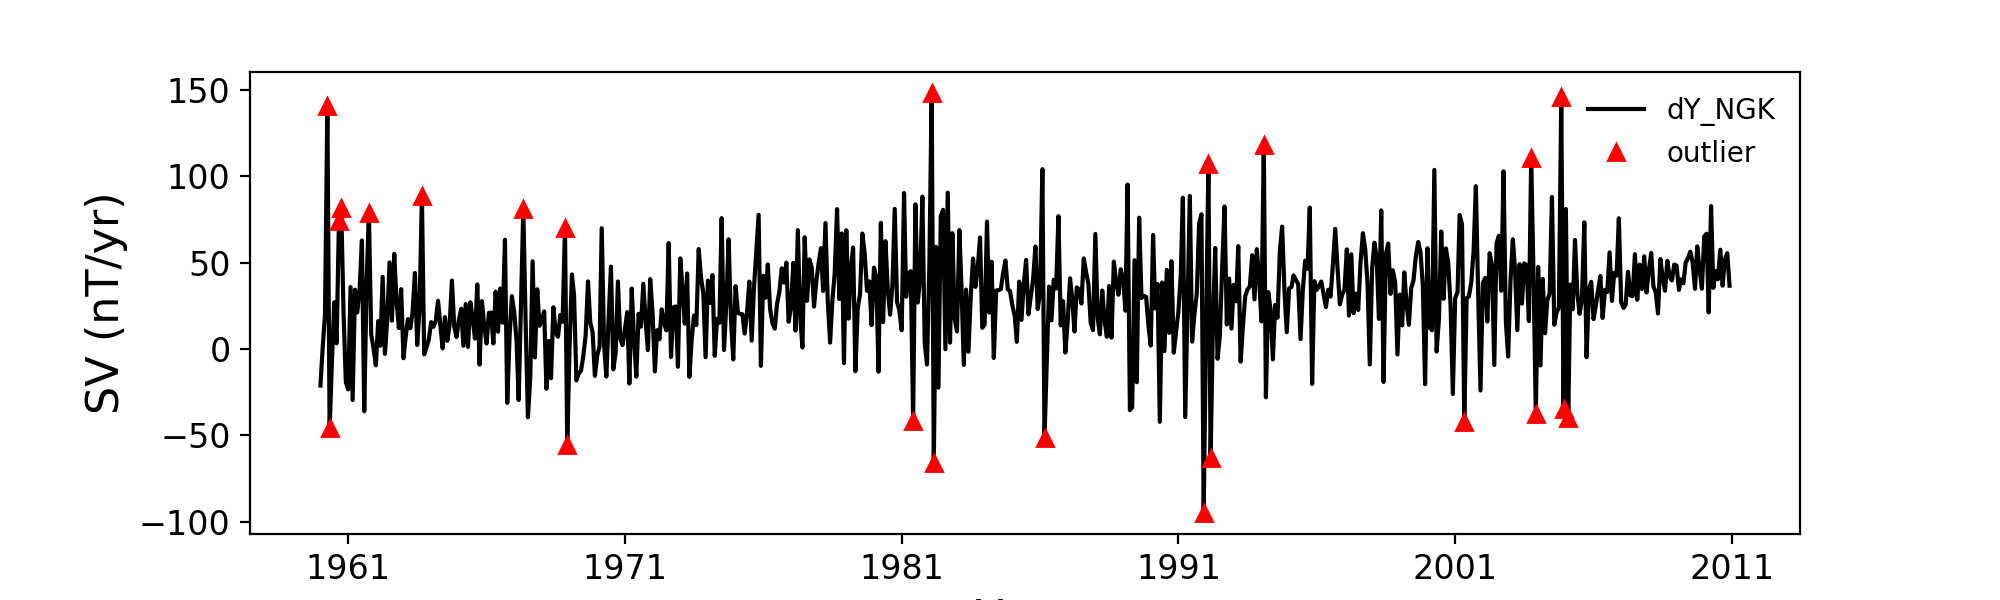

<IPython.core.display.Javascript object>


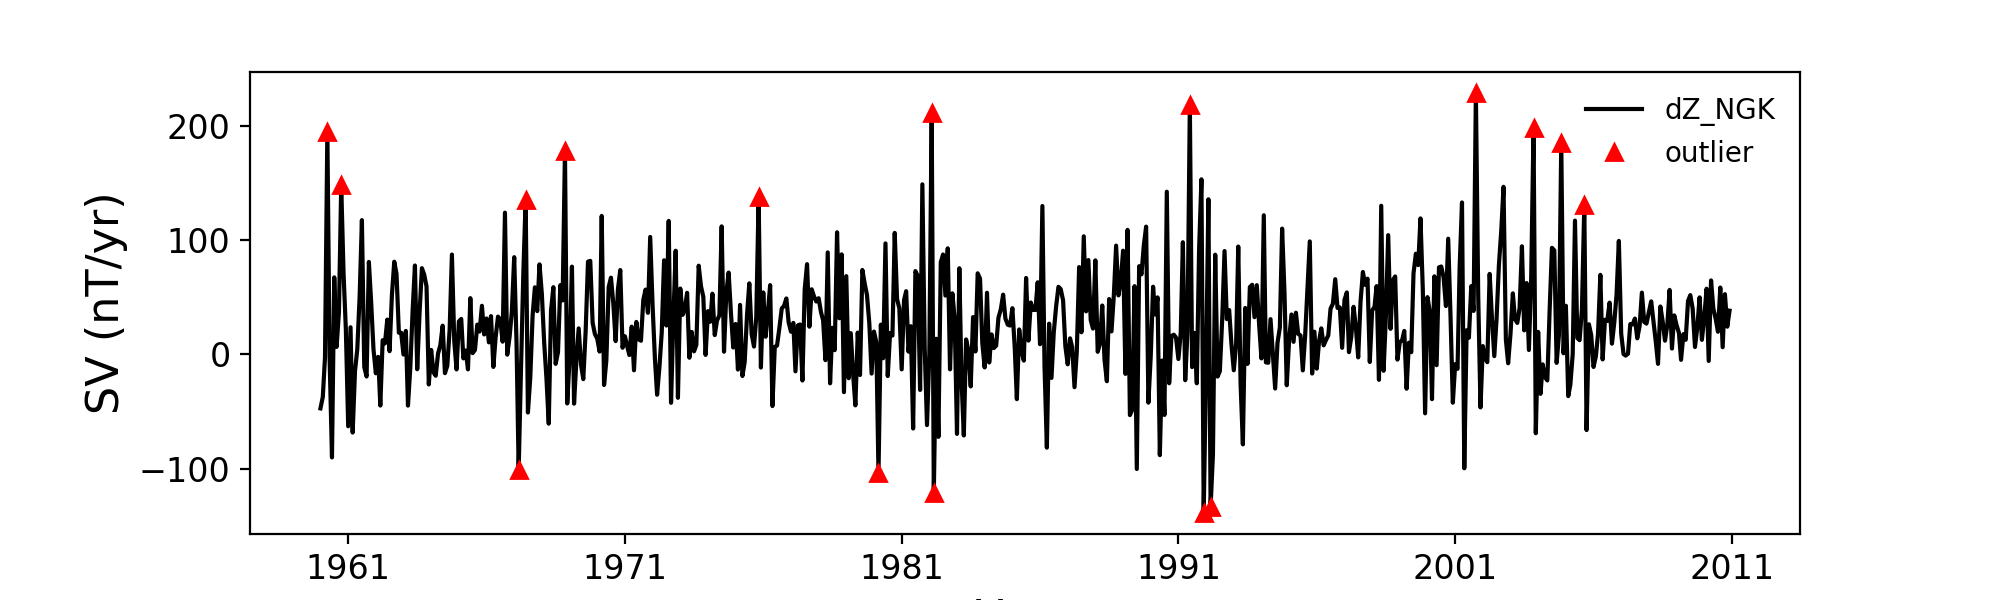

<IPython.core.display.Javascript object>


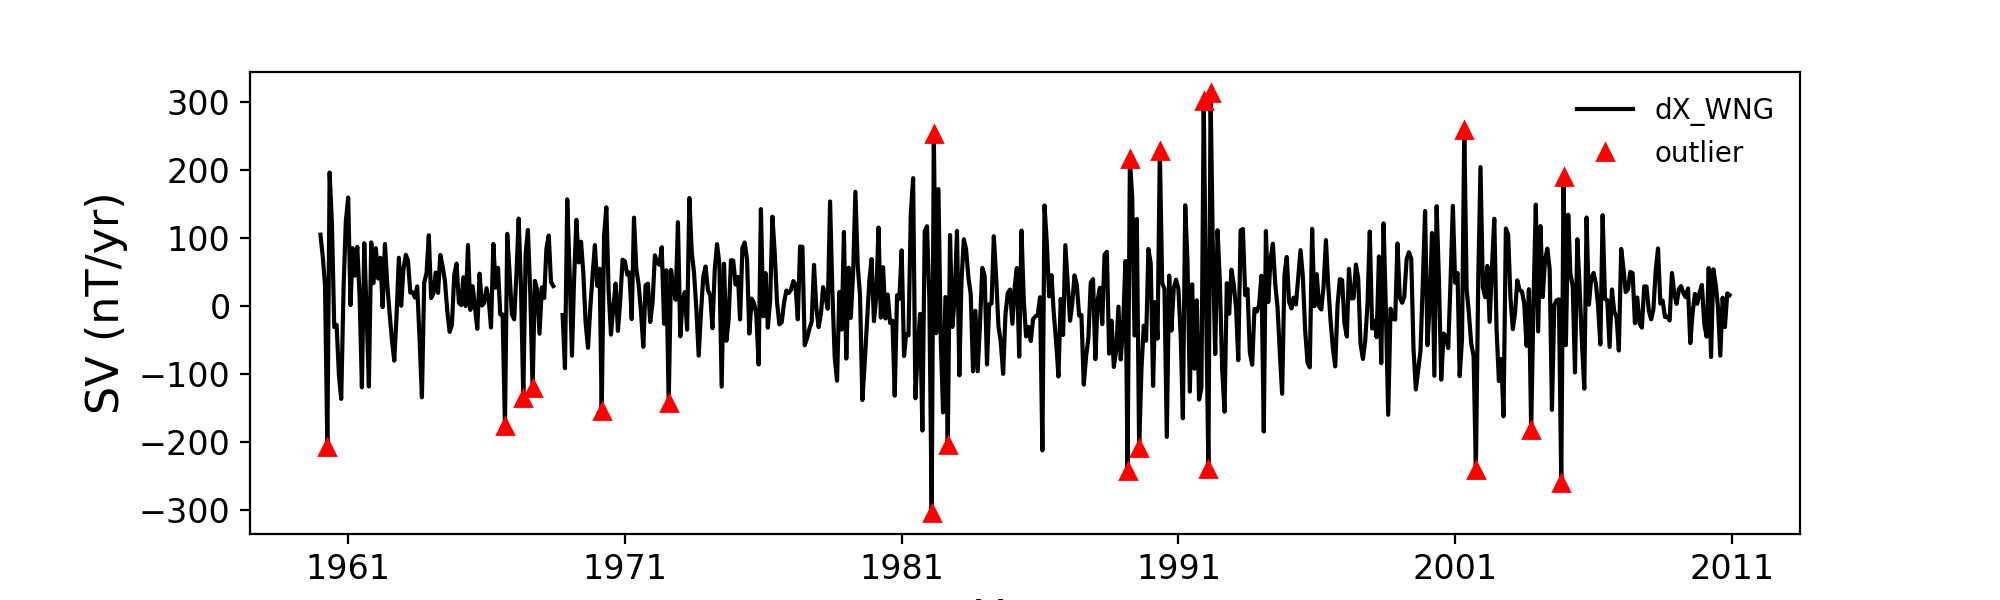

<IPython.core.display.Javascript object>


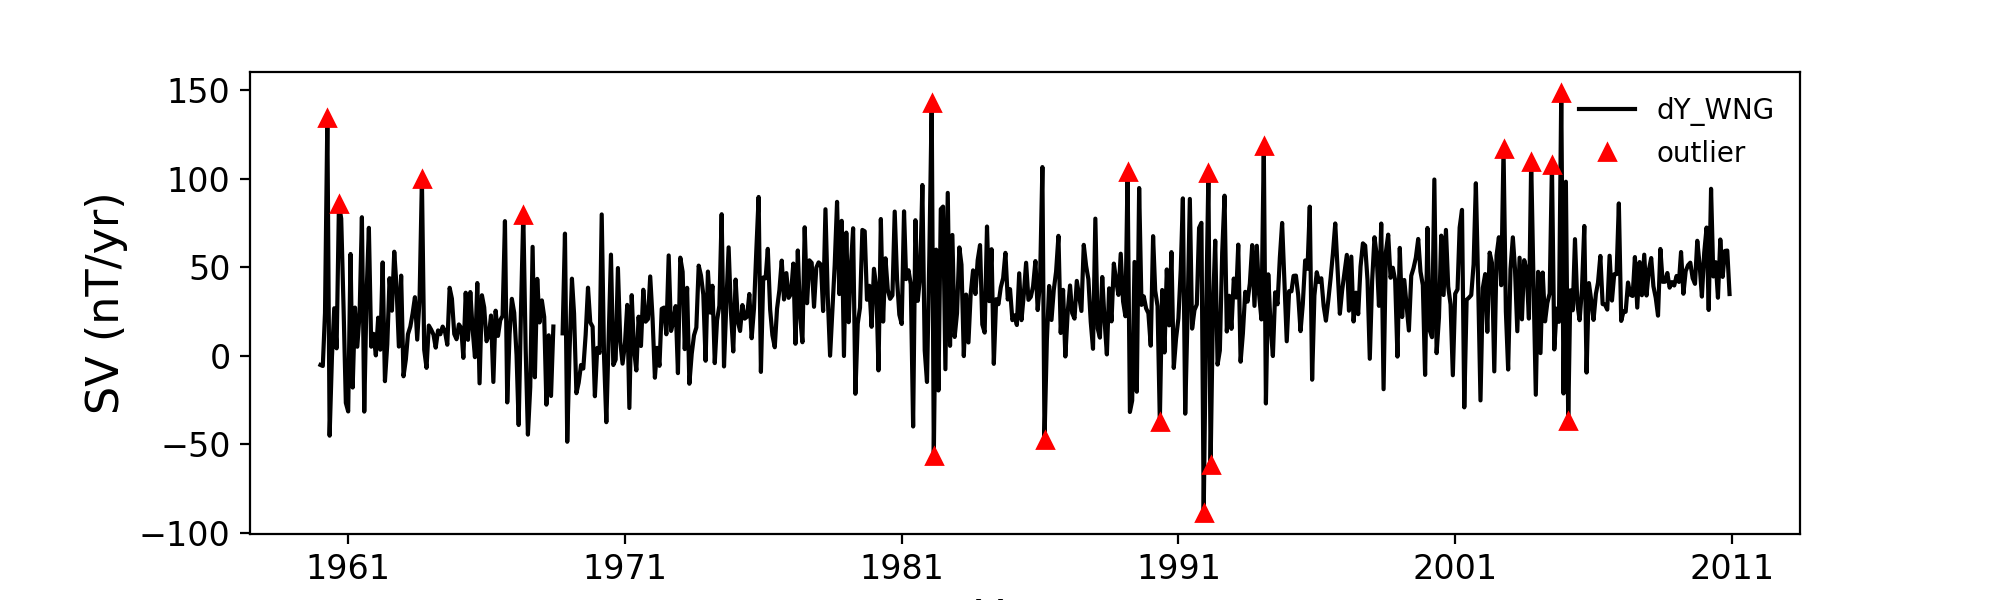

<IPython.core.display.Javascript object>


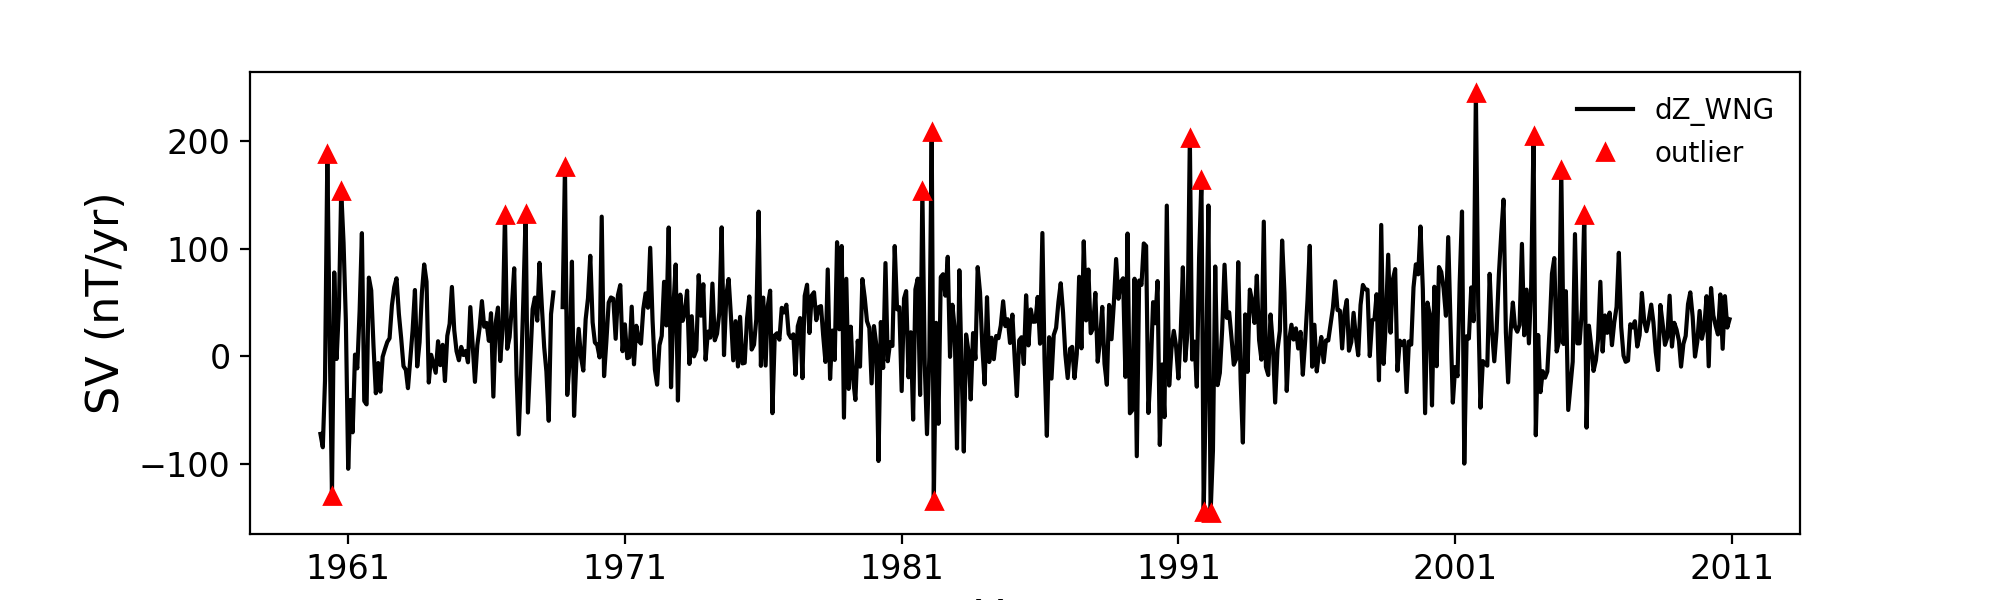

In [8]:
obs_data.drop(['date'], axis=1, inplace=True)
for column in obs_data:    
    obs_data[column] = denoise.detect_outliers(dates=dates, signal=obs_data[column], obs_name=column,
                                               threshold=3,
                                               window_length=120, plot_fig=True, fig_size=(10,3))
obs_data.insert(0, 'date', dates)

# External noise removal

Compute the residuals and use the eigenvalues/vectors of the covariance matrix to remove unmodelled external signal (Wardinski & Holme, 2011)

In [9]:
residuals = svtools.calculate_residuals(obs_data=obs_data, model_data=model_sv_data)

In [10]:
model_sv_data.drop(['date'], axis=1, inplace=True)
obs_data.drop(['date'], axis=1, inplace=True)

In [11]:
denoised, proxy, eigenvals, eigenvecs, projected_residuals, corrected_residuals = denoise.eigenvalue_analysis(
    dates=dates, obs_data=obs_data, model_data=model_sv_data, residuals=residuals,
    proxy_number=2)

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/pandas/types/cast.py:537: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype)


# Denoised SV plots

Plots showing the original SV data, the denoised data (optionally with a running average) and the field model predictions.

<IPython.core.display.Javascript object>


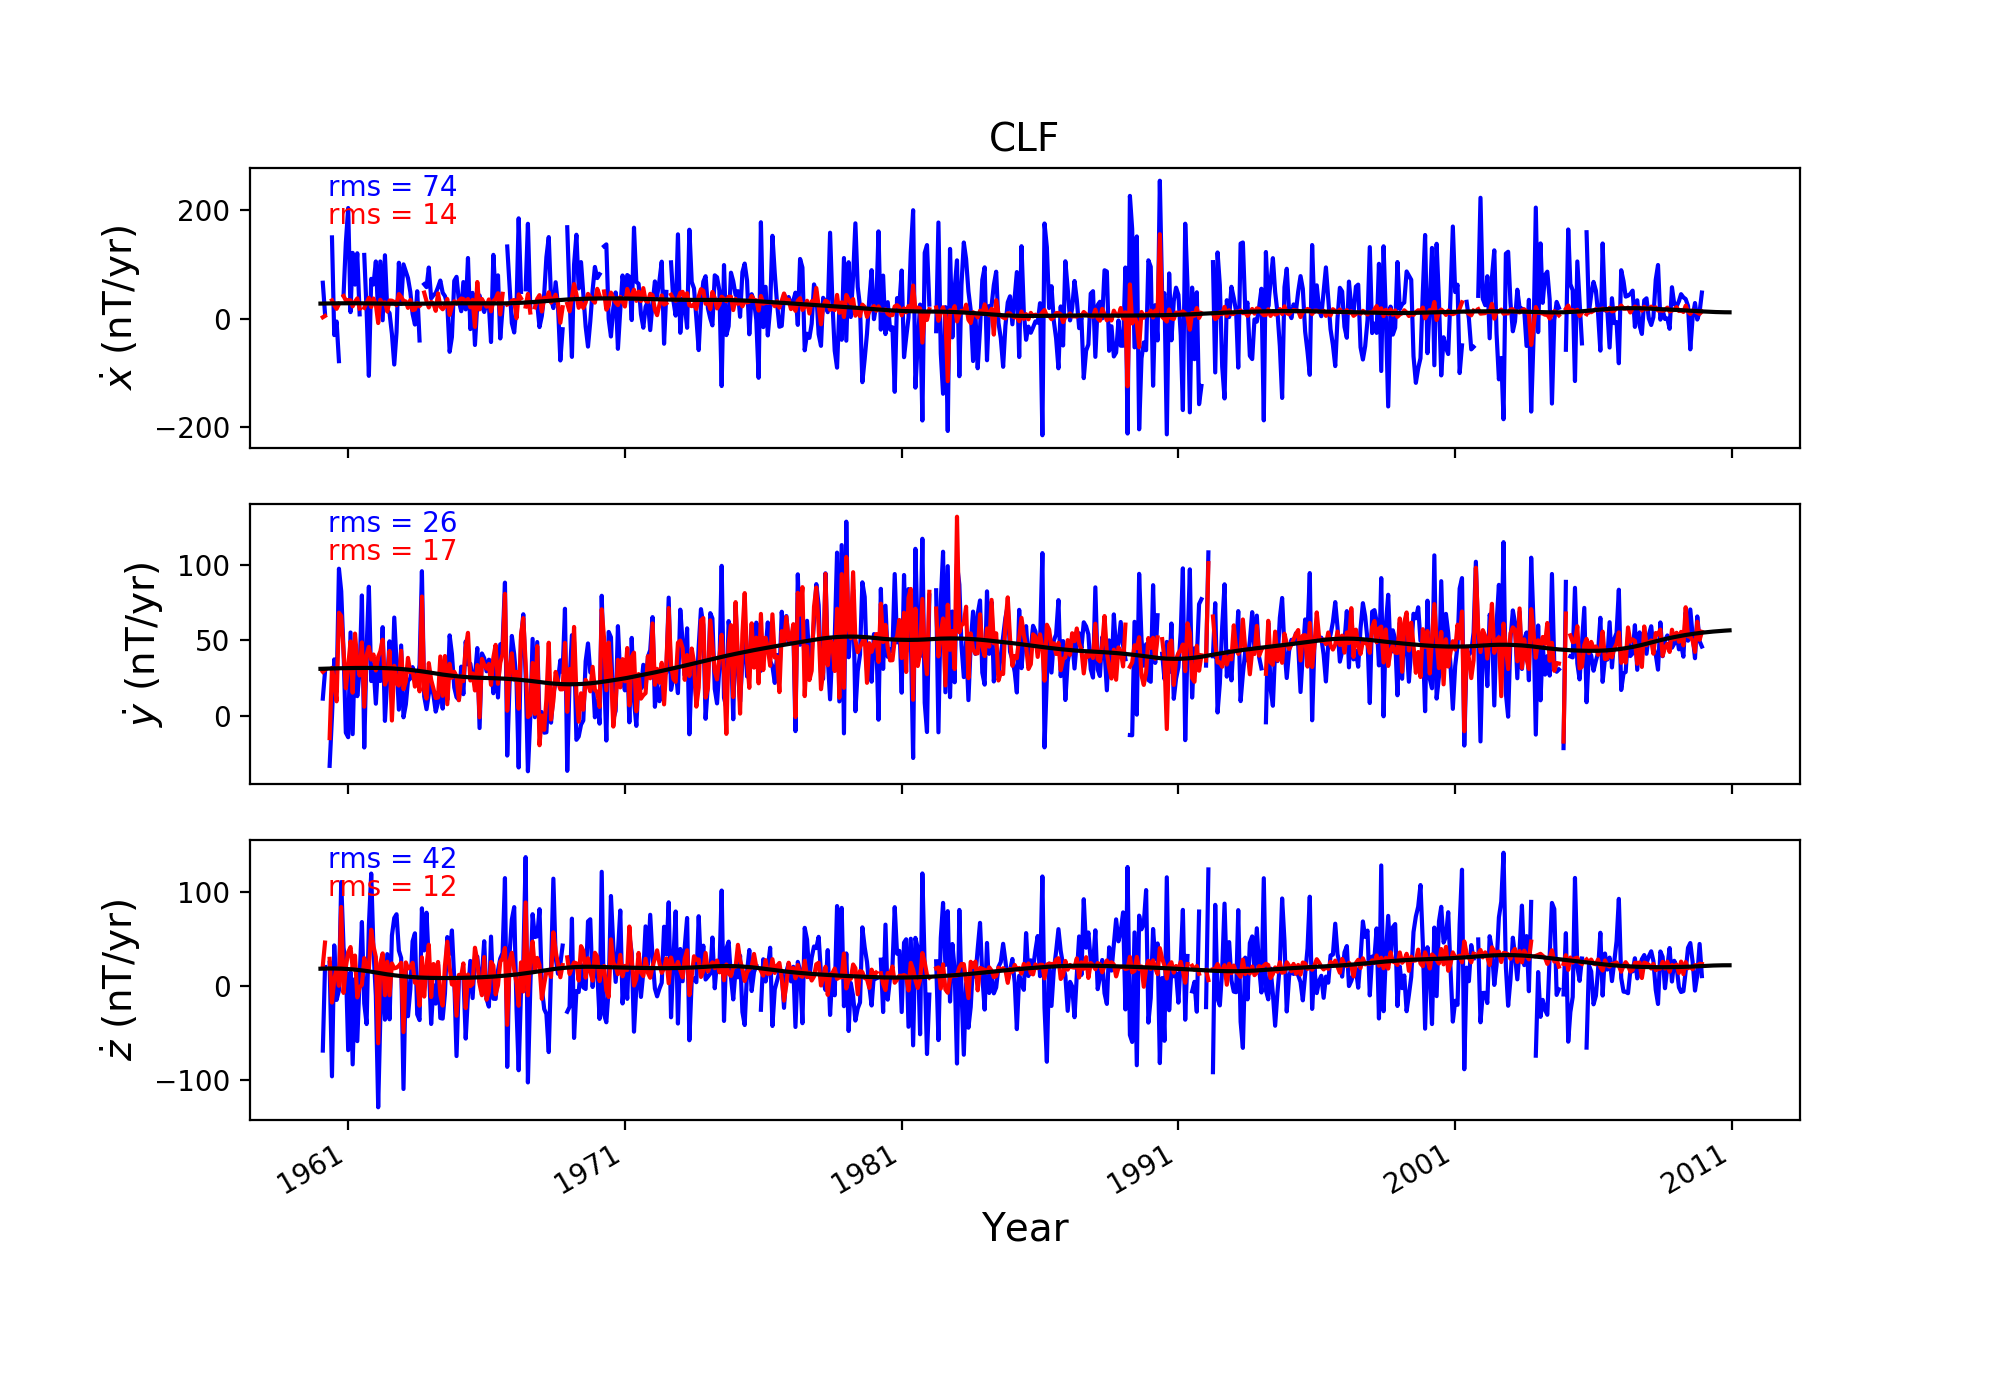

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


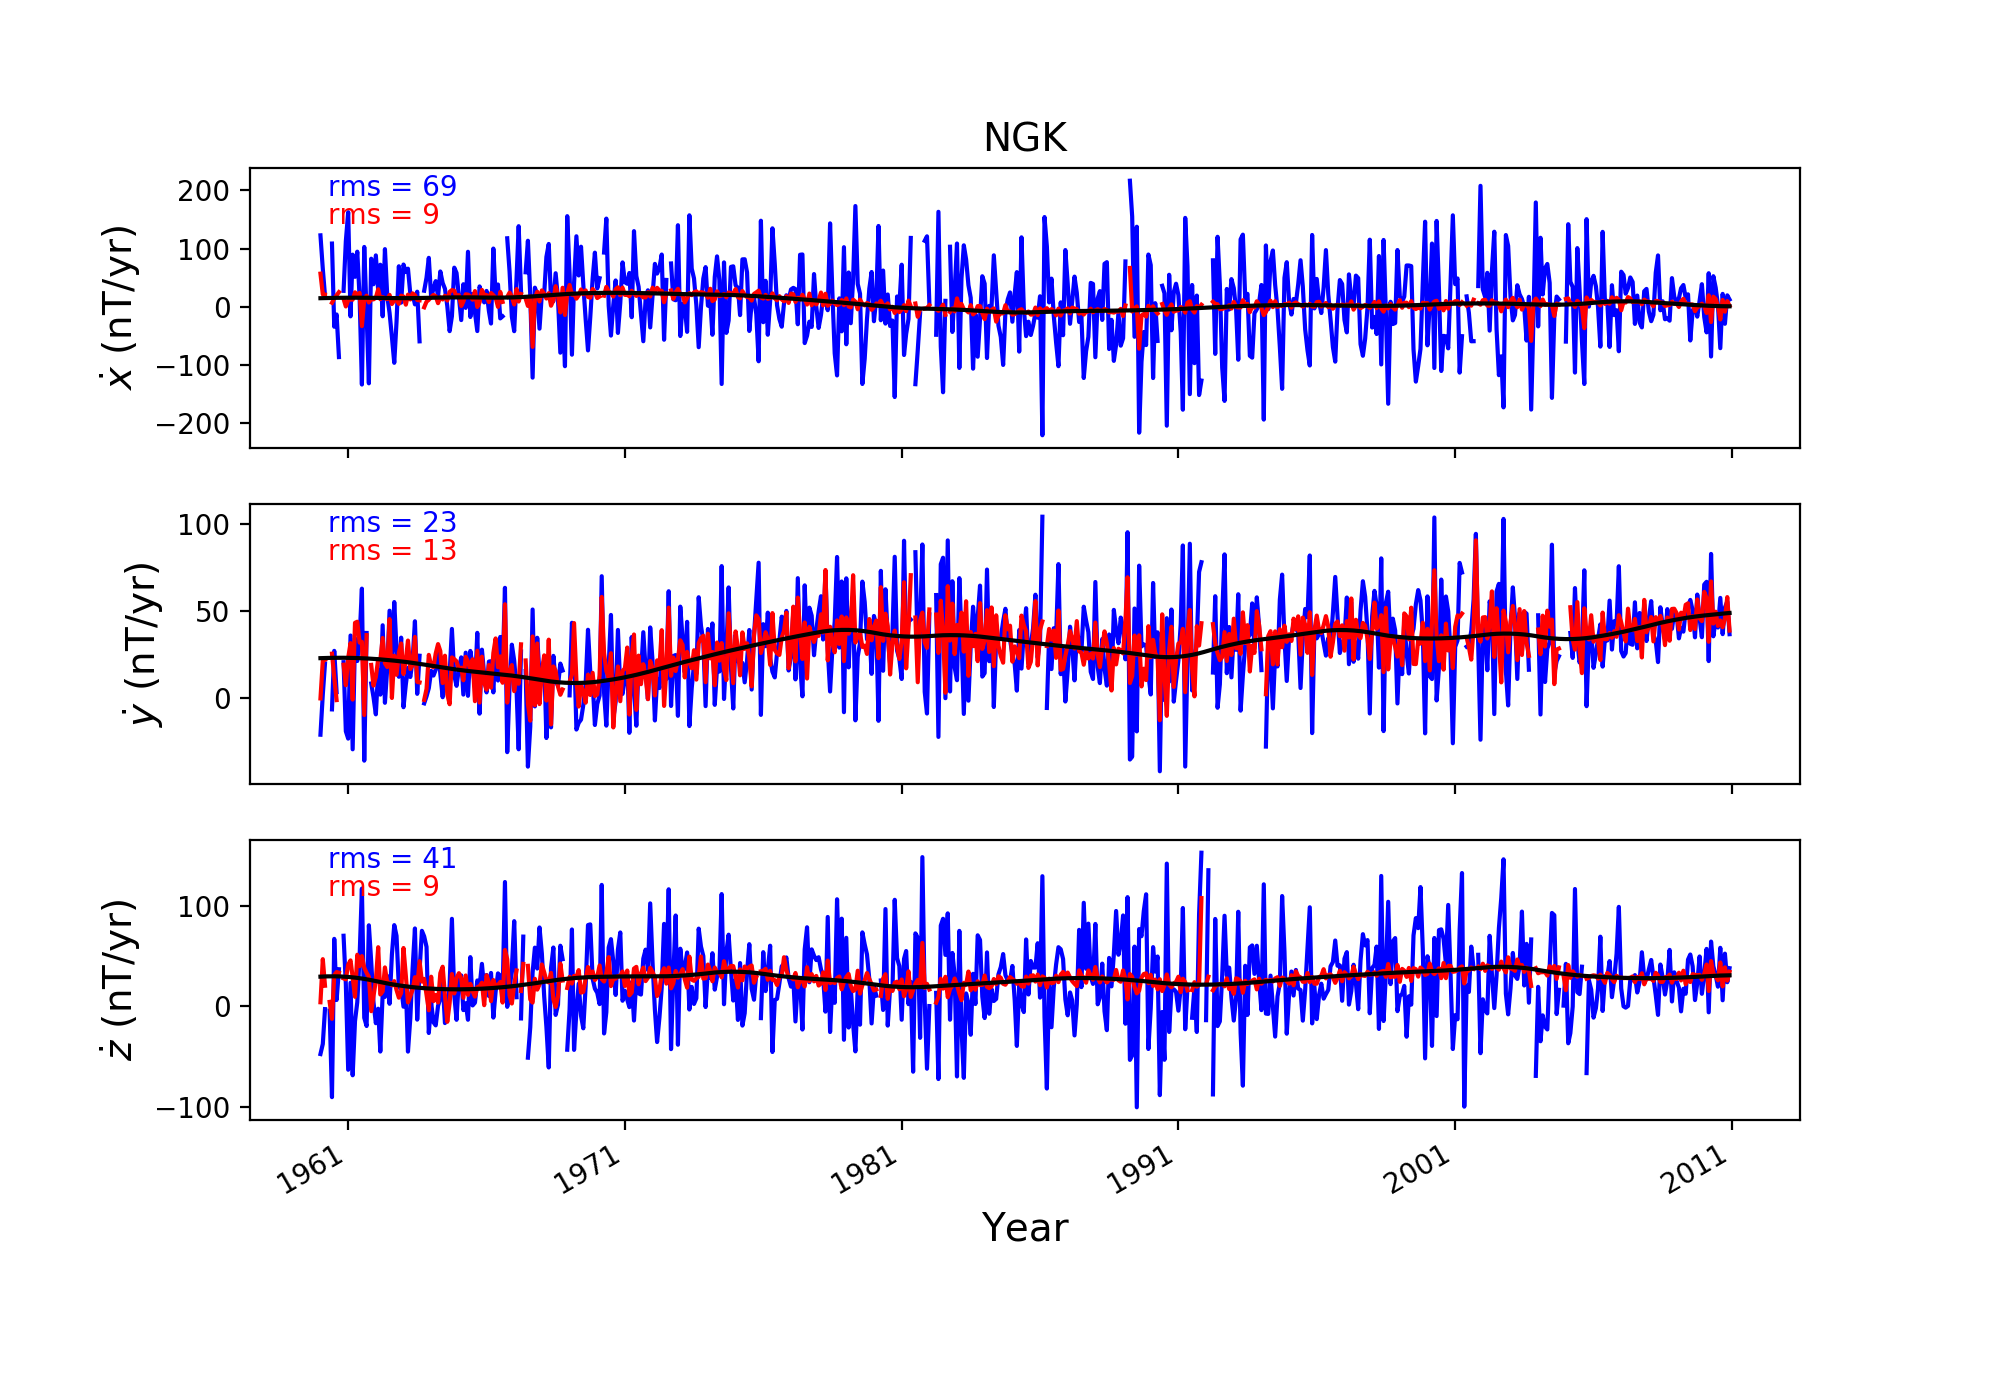

<IPython.core.display.Javascript object>


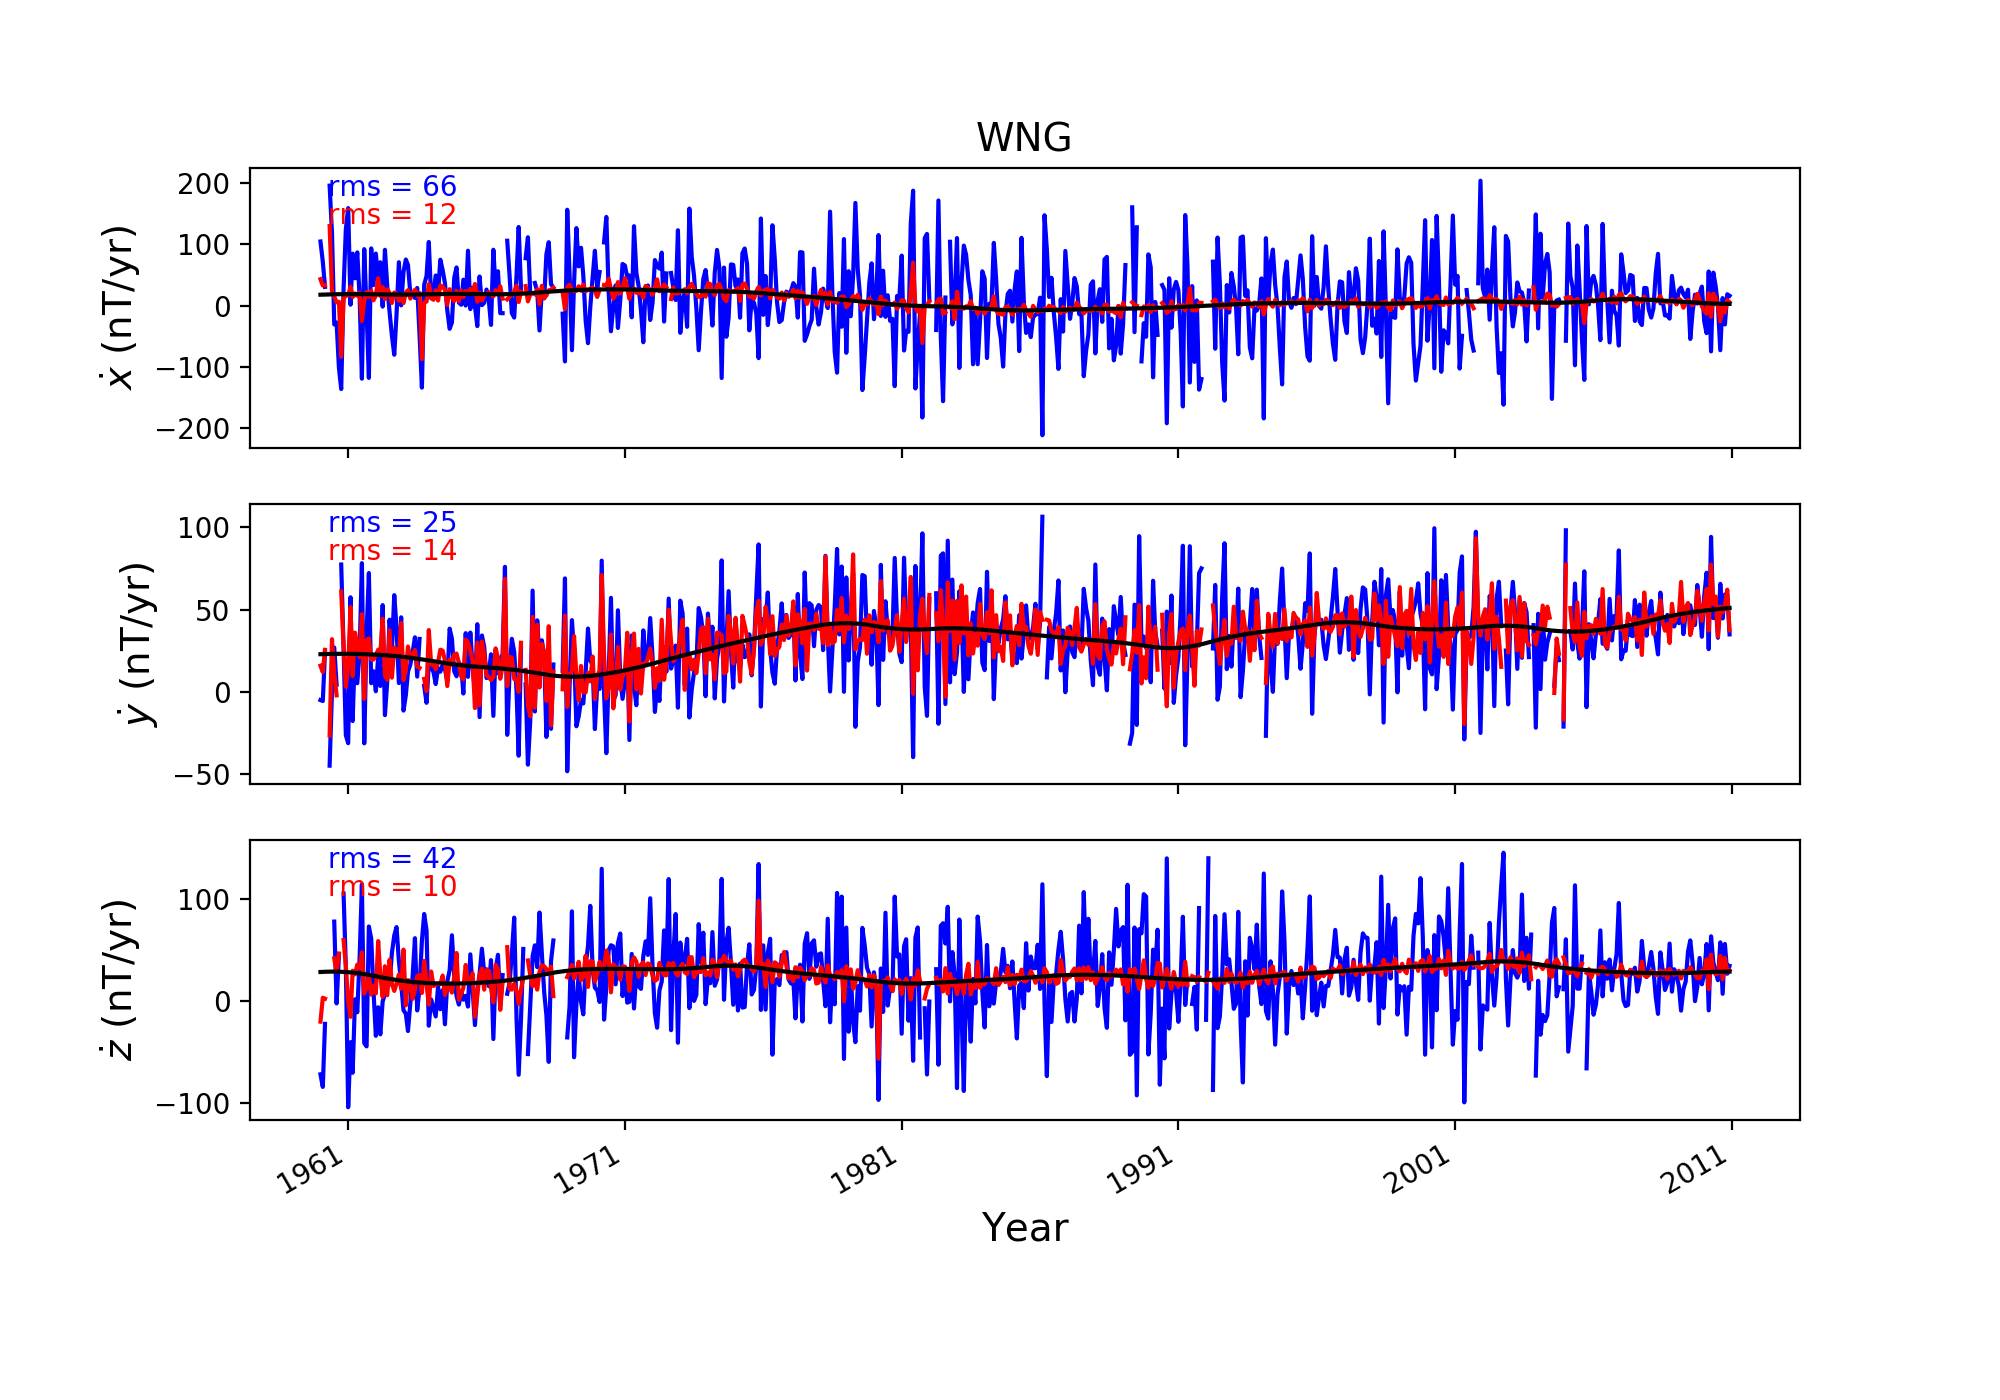

In [12]:
for observatory in observatory_list:
    xratio, yratio, zratio = svplots.plot_sv_comparison(dates=dates, denoised_sv=denoised.filter(regex=observatory),
        residuals=residuals.filter(regex=observatory),
        corrected_residuals = corrected_residuals.filter(regex=observatory),
        noisy_sv=obs_data.filter(regex=observatory), model=model_sv_data.filter(regex=observatory),
        model_name='COV-OBS',
        fig_size=(10, 7), font_size=10, label_size=14, obs=observatory, plot_rms=True)

Plots showing the denoised data (optionally with a running average) and the field model predictions.

In [ ]:
for observatory in observatory_list:
    svplots.plot_sv(dates=dates, sv=denoised.filter(regex=observatory), model=model_sv_data.filter(regex=observatory),
                    fig_size=(10, 5), font_size=10, label_size=14, plot_legend=False, obs=observatory, model_name='COV-OBS')

# Plot proxy signal, eigenvalues and eigenvectors

Compare the proxy signal used to denoise the data with the Dst index, measures the intensity of the equatorial electrojet (the "ring current"). Both signals are reduced to zero-mean and unit variance (z-score).

In [13]:
dst_file = '/Users/gracecox/Dropbox/DataDownloads/Dst/dst_fdmm.csv'

<IPython.core.display.Javascript object>


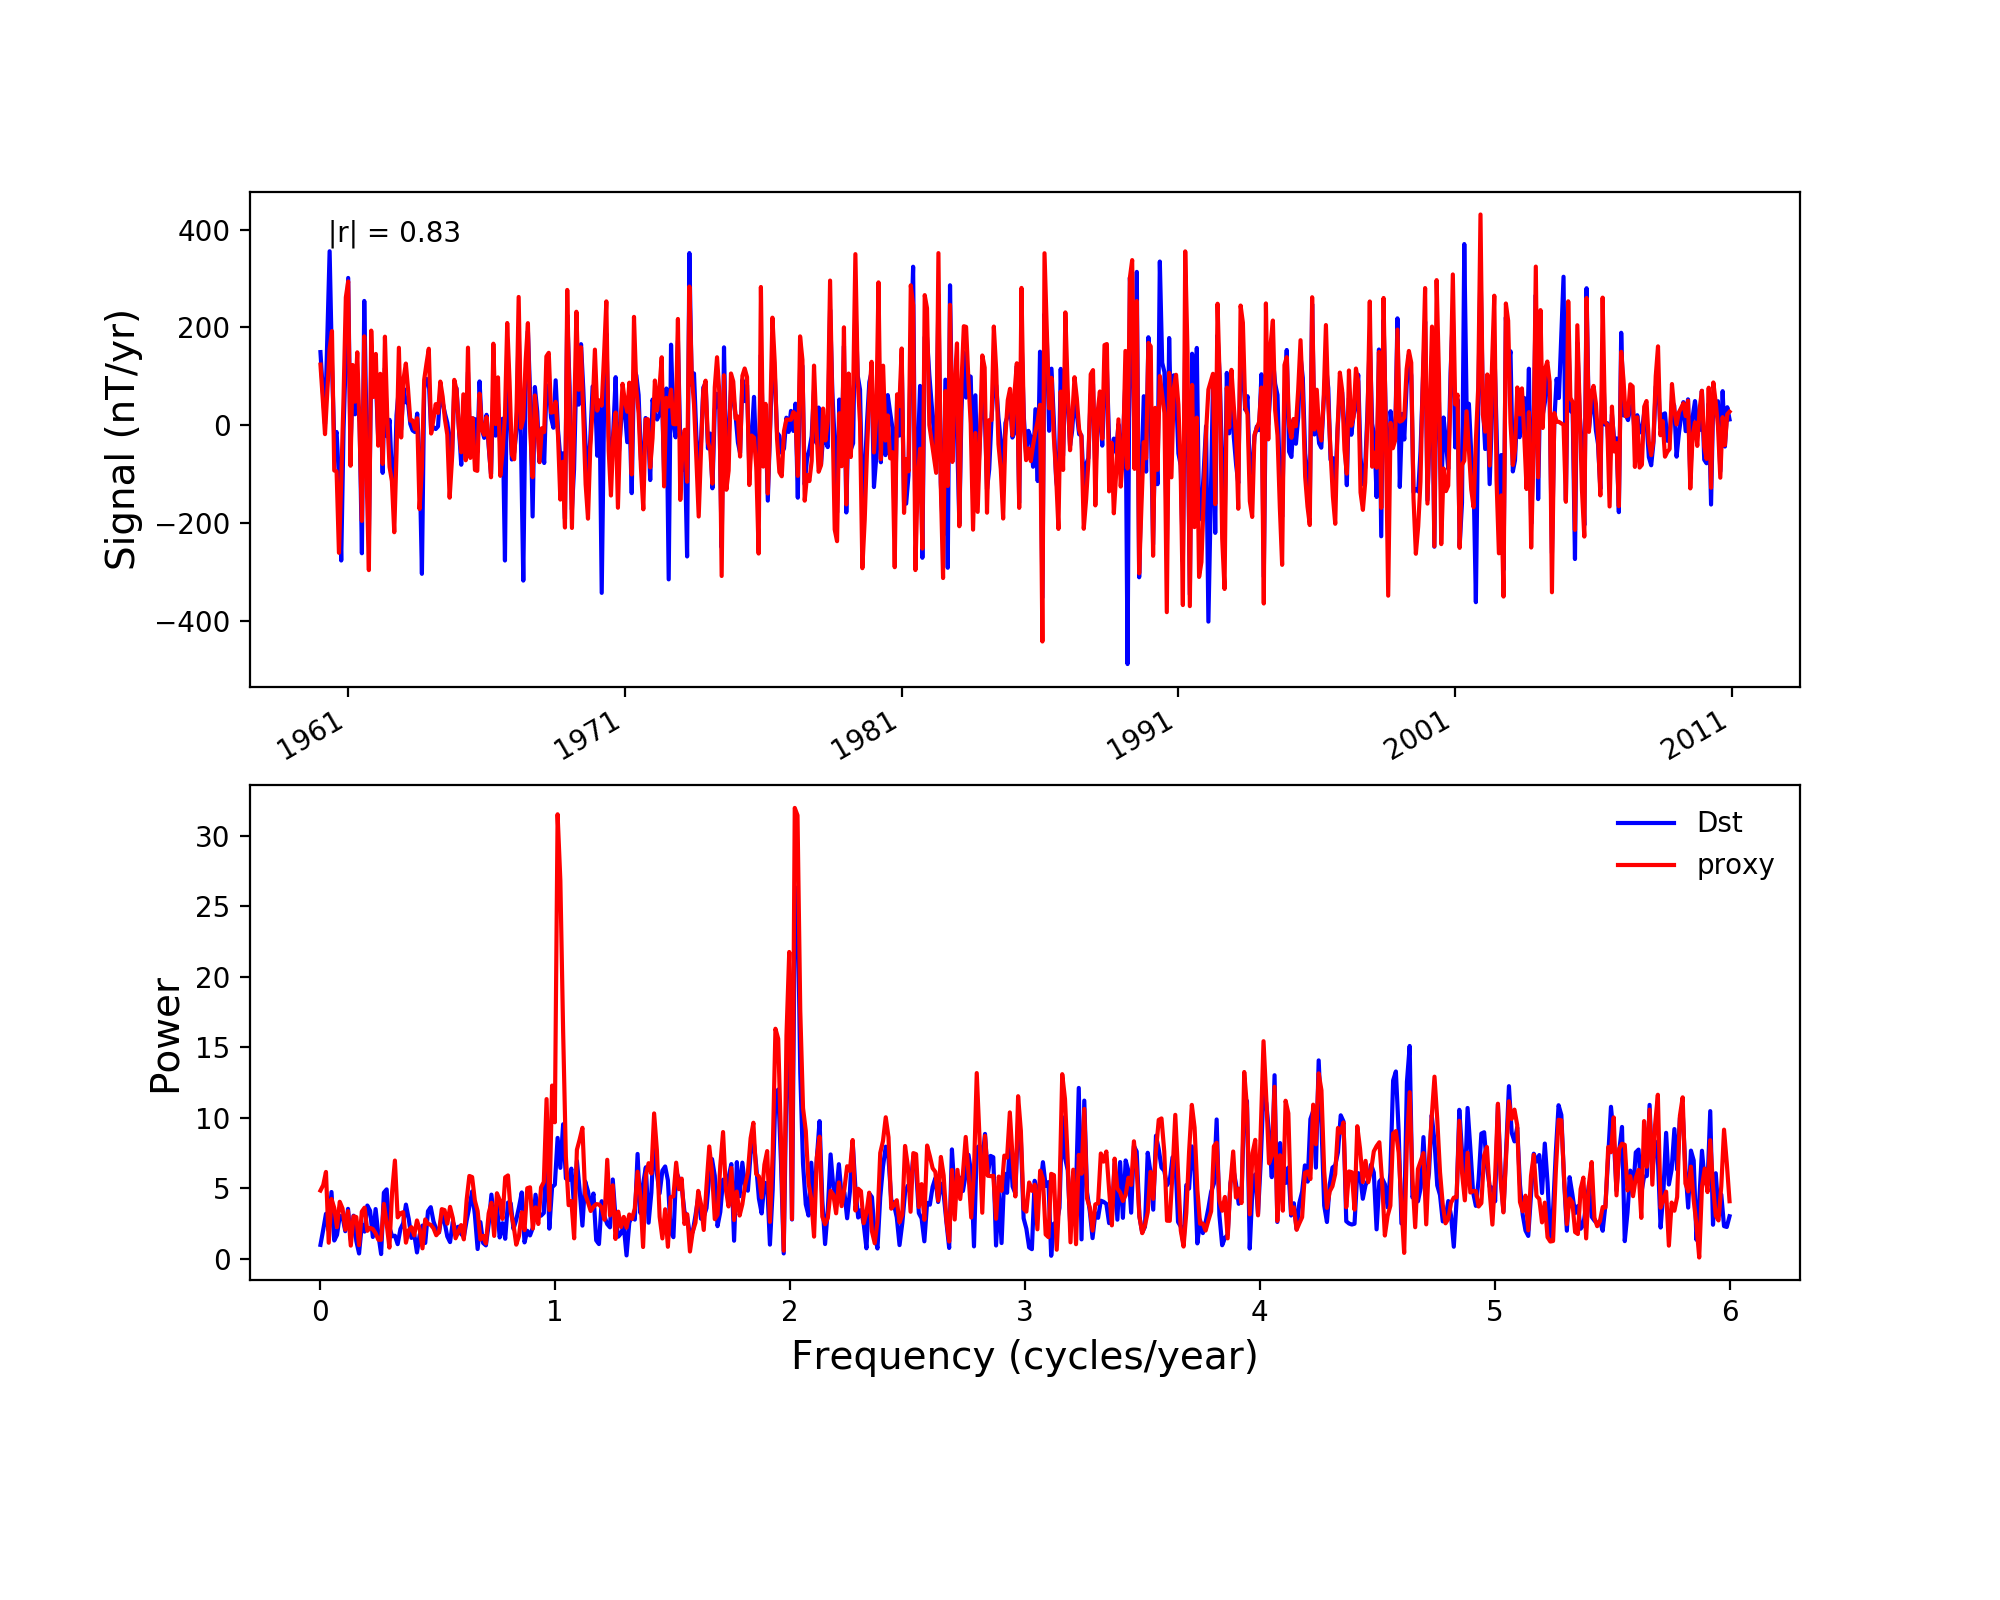

In [14]:
svplots.plot_index_dft(index_file=dst_file, dates=denoised.date, signal=proxy, fig_size=(10, 8), font_size=10,
                       label_size=14, plot_legend=True, index_name='Dst')

Plot the eigenvalues of the covariance matrix of the residuals

<IPython.core.display.Javascript object>


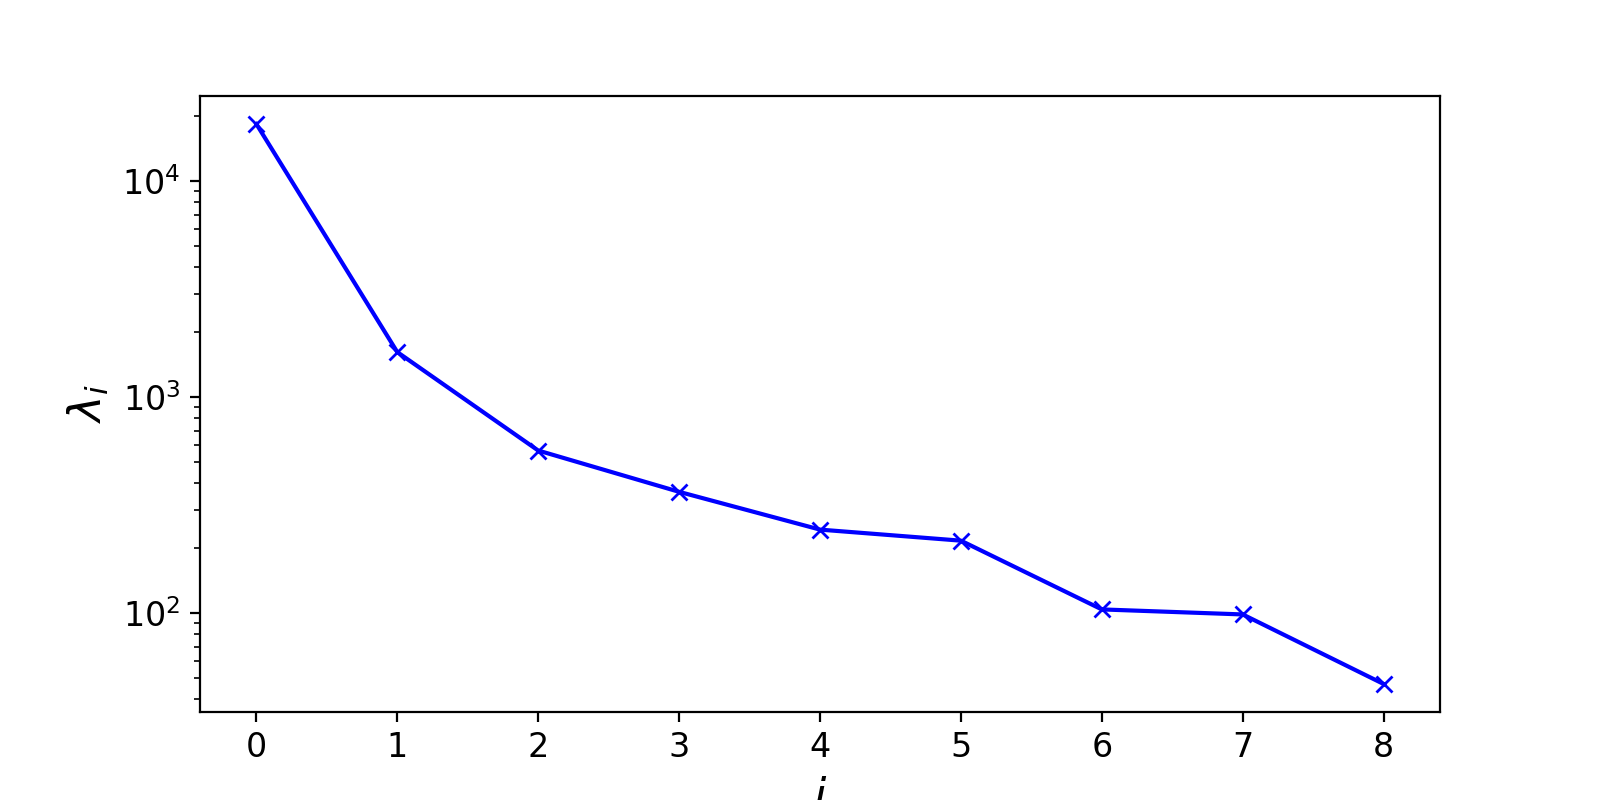

In [15]:
svplots.plot_eigenvalues(values=eigenvals, font_size=12, label_size=16, fig_size=(8, 4))

Plot the three eigenvectors corresponding to the three largest eigenvalues. The noisiest direction (used to denoise in this example) is mostly X, with some Z, which is consistent with the ring current for European observatories. The second noisiest direction (also used to denoise in this example) is predominantly Z, with some X, which is again consistent with rind current directions. However, the third noisiest direction is a coherent Y signal across Europe, which does not correspond to a known direction of external signal. We did not remove this direction during denoising as it could be a real internal field variation that is not captured by the field model.

<IPython.core.display.Javascript object>


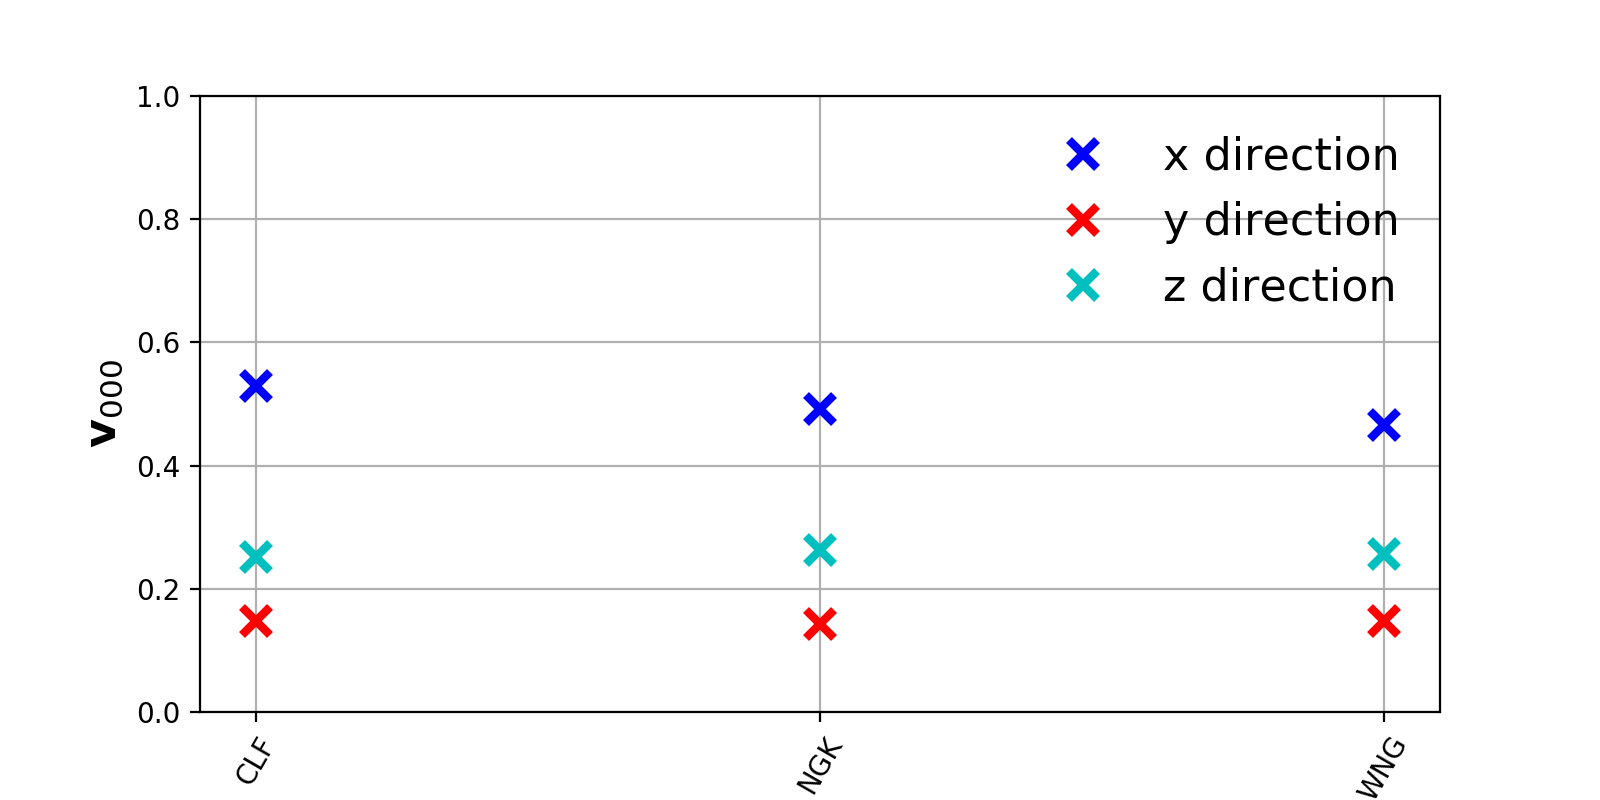

<IPython.core.display.Javascript object>


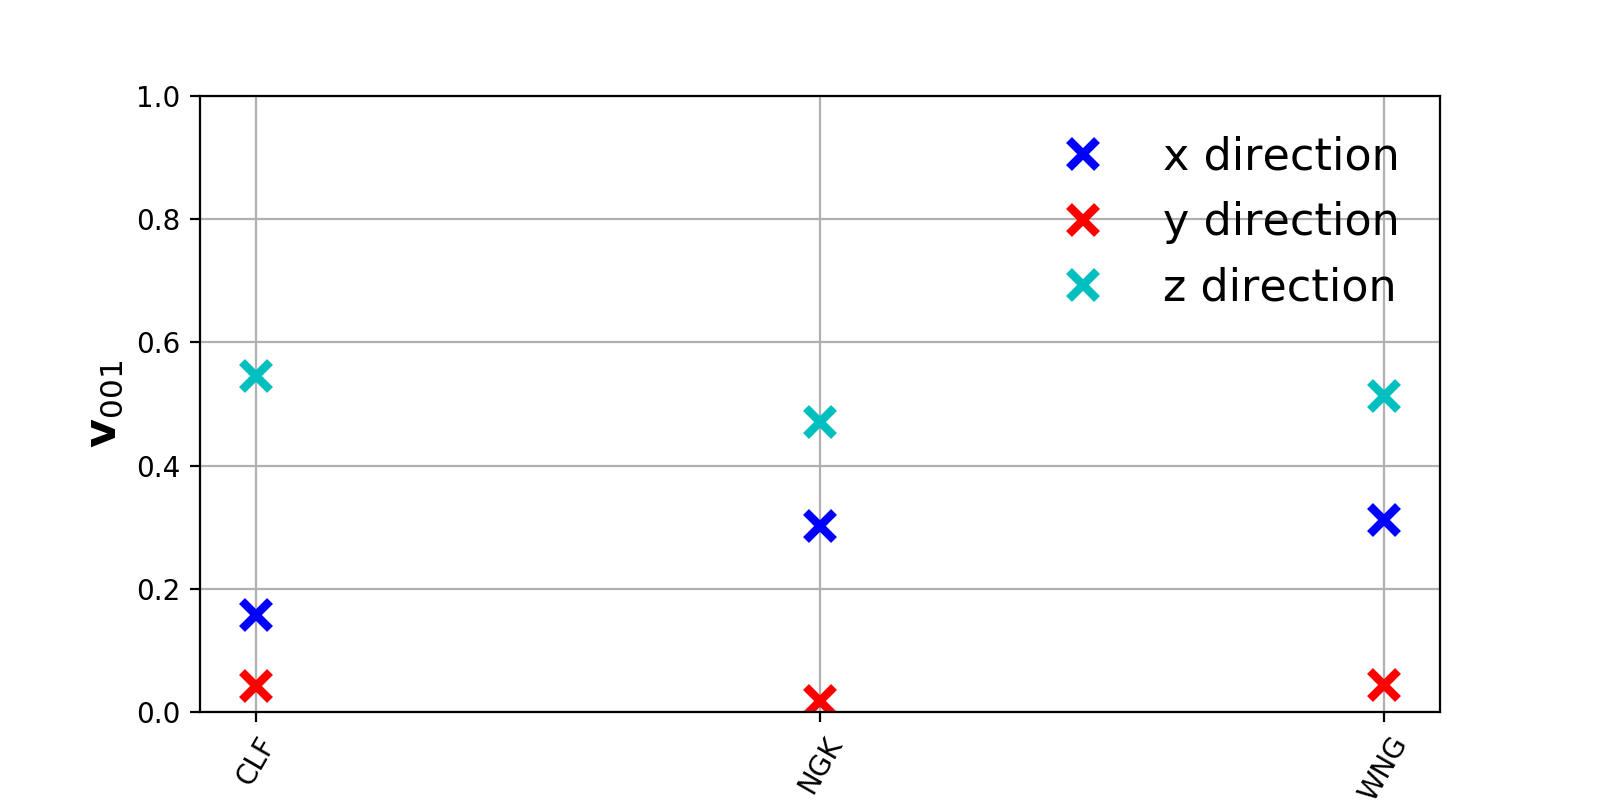

<IPython.core.display.Javascript object>


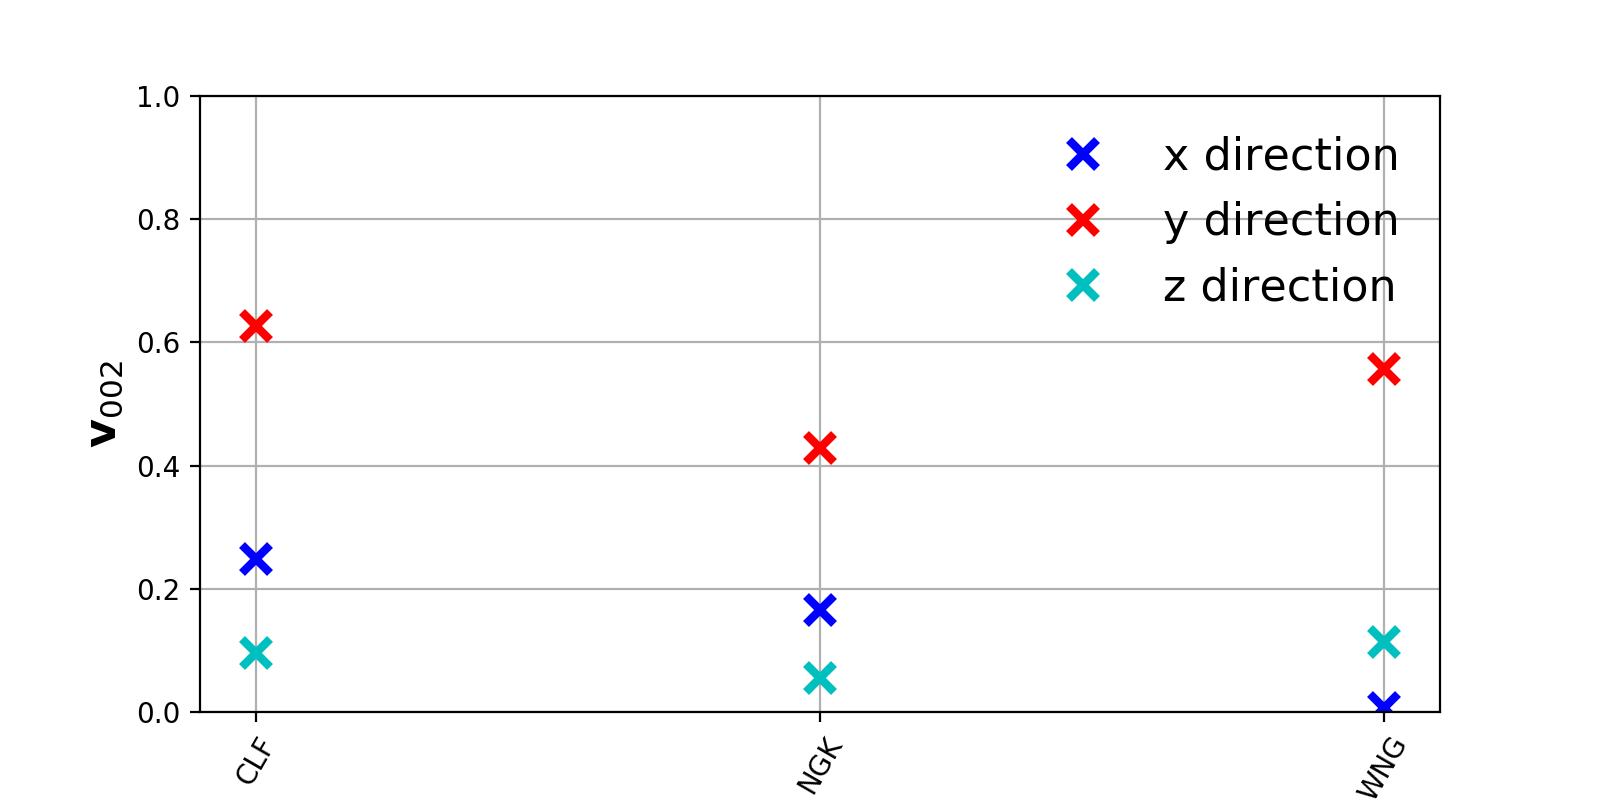

In [16]:
svplots.plot_eigenvectors(obs_names=observatory_list, eigenvecs=eigenvecs[:,0:3], fig_size=(8, 4),
                          font_size=10, label_size=16)

# Outlier detection

Remove remaining spikes in the time series.

In [17]:
denoised.drop(['date'], axis=1, inplace=True)
for column in denoised:
    denoised[column] = denoise.detect_outliers(dates=dates, signal=denoised[column], obs_name=column, threshold=5,
                                               window_length=120, plot_fig=False, fig_size=(10, 3), font_size=10, label_size=14)
denoised.insert(0, 'date', dates)

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/window.py:222: UserWarning: Warning: converting a masked element to nan.
  values = _ensure_float64(values)
/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/pandas/types/cast.py:537: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype)
/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Write denoised data to file

In [ ]:
for observatory in observatory_list:
    print(observatory)
    sv_data=denoised.filter(regex=observatory)
    sv_data.insert(0, 'date', dates)
    sv_data.columns = ["date", "dX", "dY", "dZ"]
    inputoutput.write_csv_data(data=sv_data, write_path=download_dir + '/denoised/european/',
                               obs_name=observatory, decimal_dates=False)

# Averaging data over Europe

Select denoised data for each SV component at all observatories

In [18]:
obs_X = denoised.filter(regex='dX')
model_X = model_sv_data.filter(regex='dX')
obs_Y = denoised.filter(regex='dY')
model_Y = model_sv_data.filter(regex='dY')
obs_Z = denoised.filter(regex='dZ')
model_Z = model_sv_data.filter(regex='dZ')

Average data and model for each component

In [19]:
mean_X = pd.DataFrame(np.mean(obs_X.values, axis=1))
mean_X.columns = ['dX']
mean_model_X = np.mean(model_X, axis=1)
mean_Y = pd.DataFrame(np.mean(obs_Y.values, axis=1))
mean_Y.columns = ['dY']
mean_model_Y = np.mean(model_Y, axis=1)
mean_Z = pd.DataFrame(np.mean(obs_Z.values, axis=1))
mean_Z.columns = ['dZ']
mean_model_Z = np.mean(model_Z, axis=1)

Remove outliers from averaged data

In [20]:
mean_X = denoise.detect_outliers(dates=dates, signal=mean_X, obs_name='X', threshold=2.5,
                                               window_length=72, plot_fig=False, fig_size=(10, 3), font_size=10, label_size=14)
mean_Y = denoise.detect_outliers(dates=dates, signal=mean_Y, obs_name='Y', threshold=2.5,
                                               window_length=72, plot_fig=False, fig_size=(10, 3), font_size=10, label_size=14)
mean_Z = denoise.detect_outliers(dates=dates, signal=mean_Z, obs_name='Z', threshold=2.5,
                                               window_length=72, plot_fig=False, fig_size=(10, 3), font_size=10, label_size=14)

Look at model predictions for all observatories, and the averaged model, to see if the average is representative of the trend at all locations

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


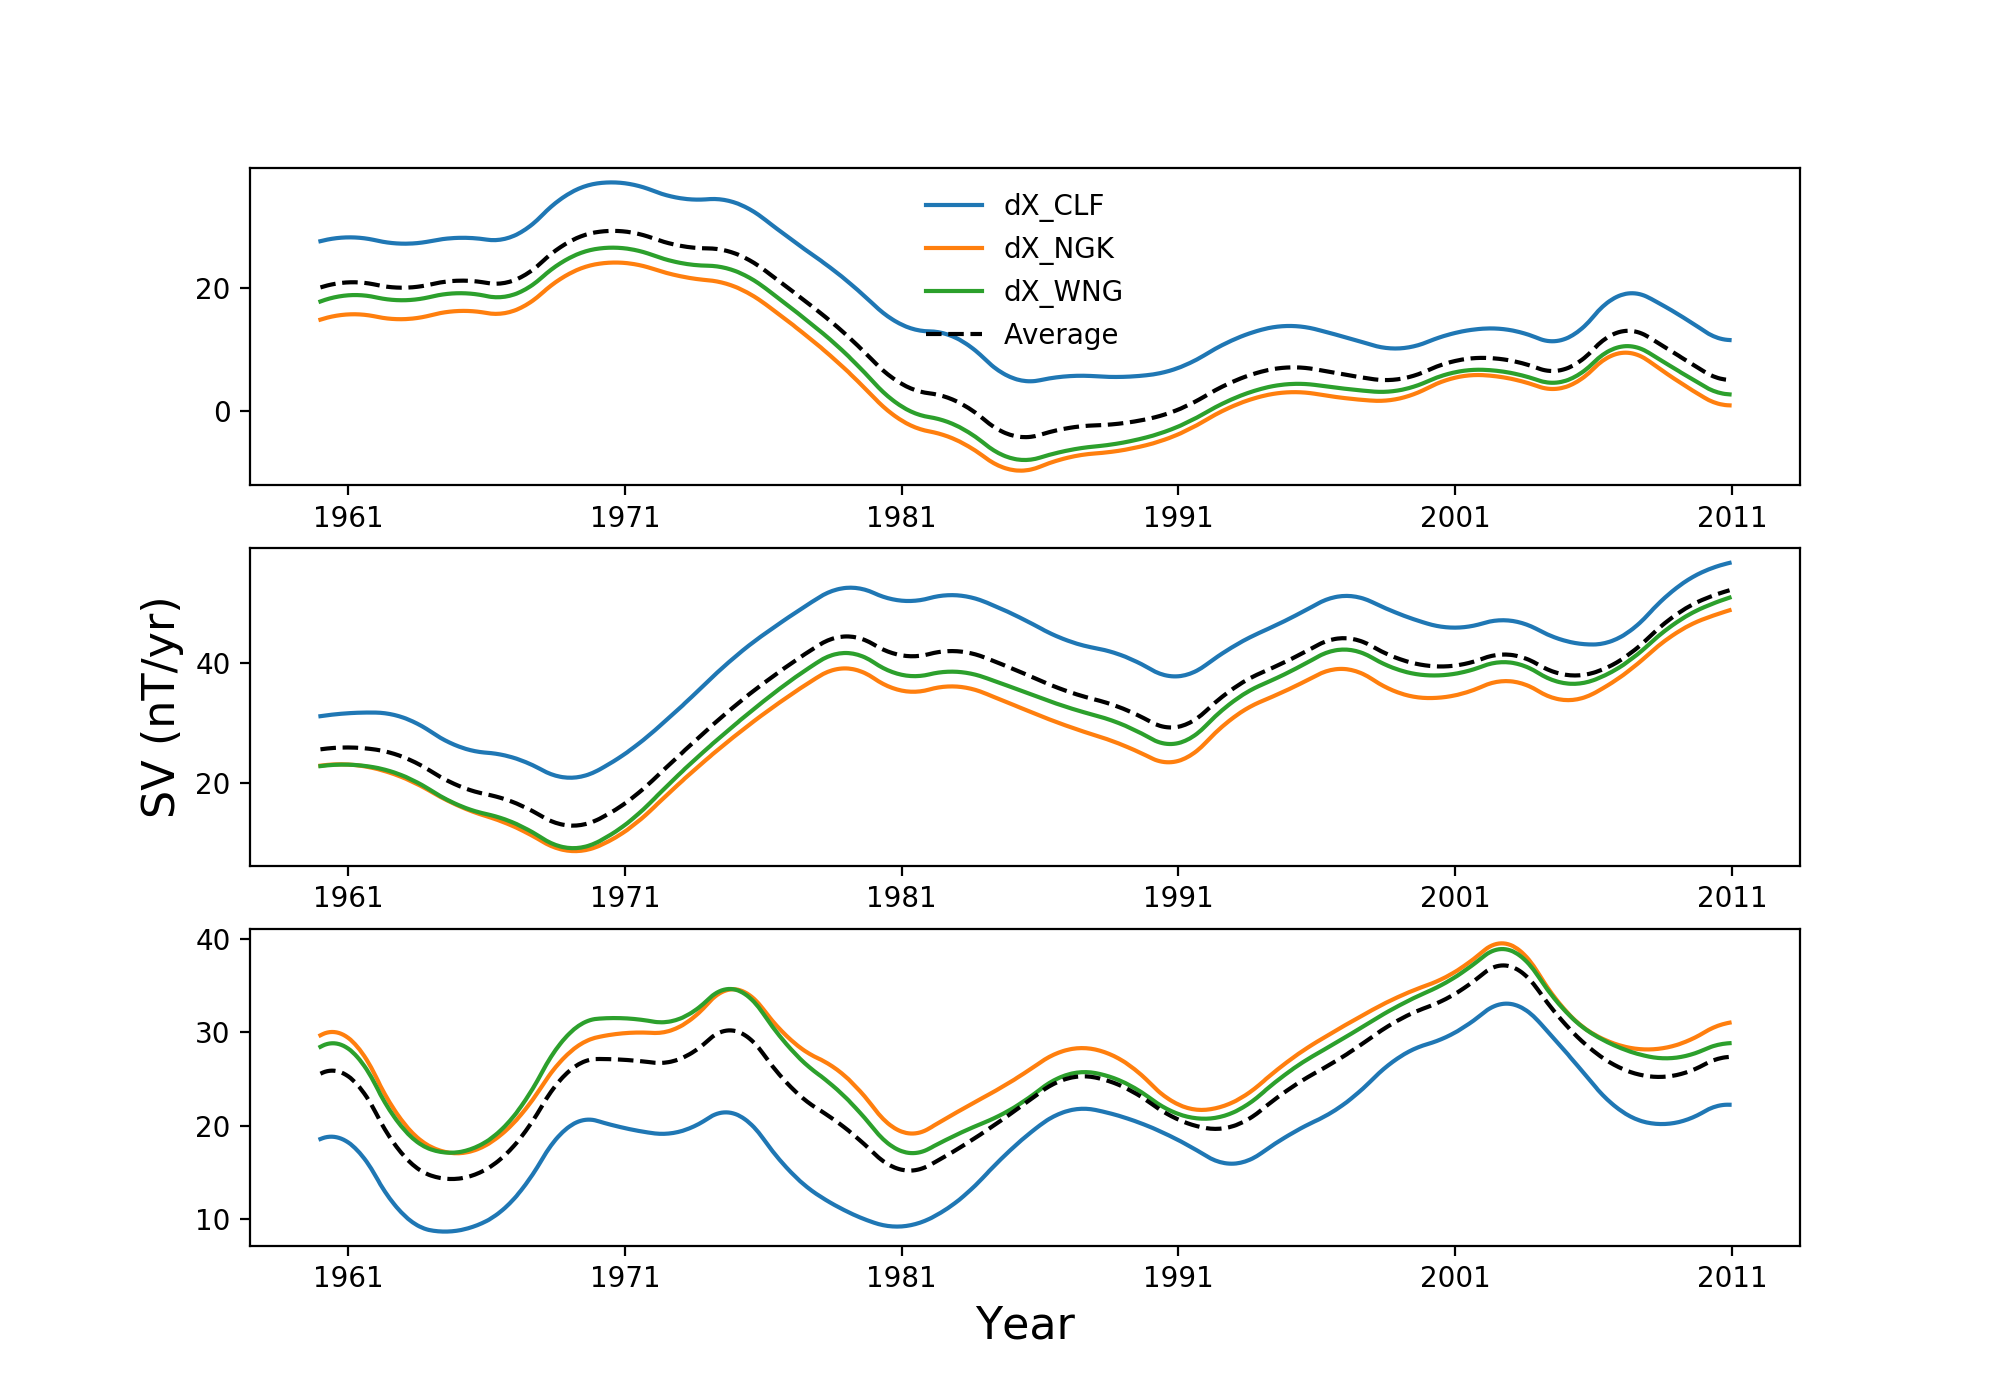

In [21]:
plt.figure(figsize=(10,7))
plt.subplot(3, 1, 1)
plt.plot(dates, model_X)
plt.plot(dates, mean_model_X, 'k--')
legend = model_X.columns.tolist()
legend.append('Average')
plt.legend(legend, frameon=False)
plt.subplot(3, 1, 2)
plt.plot(dates, model_Y)
plt.plot(dates, mean_model_Y, 'k--')
plt.ylabel('SV (nT/yr)',  fontsize=16)
plt.subplot(3, 1, 3)
plt.plot(dates, model_Z)
plt.plot(dates, mean_model_Z, 'k--')
plt.xlabel('Year',  fontsize=16)

Plot the averaged data and model

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


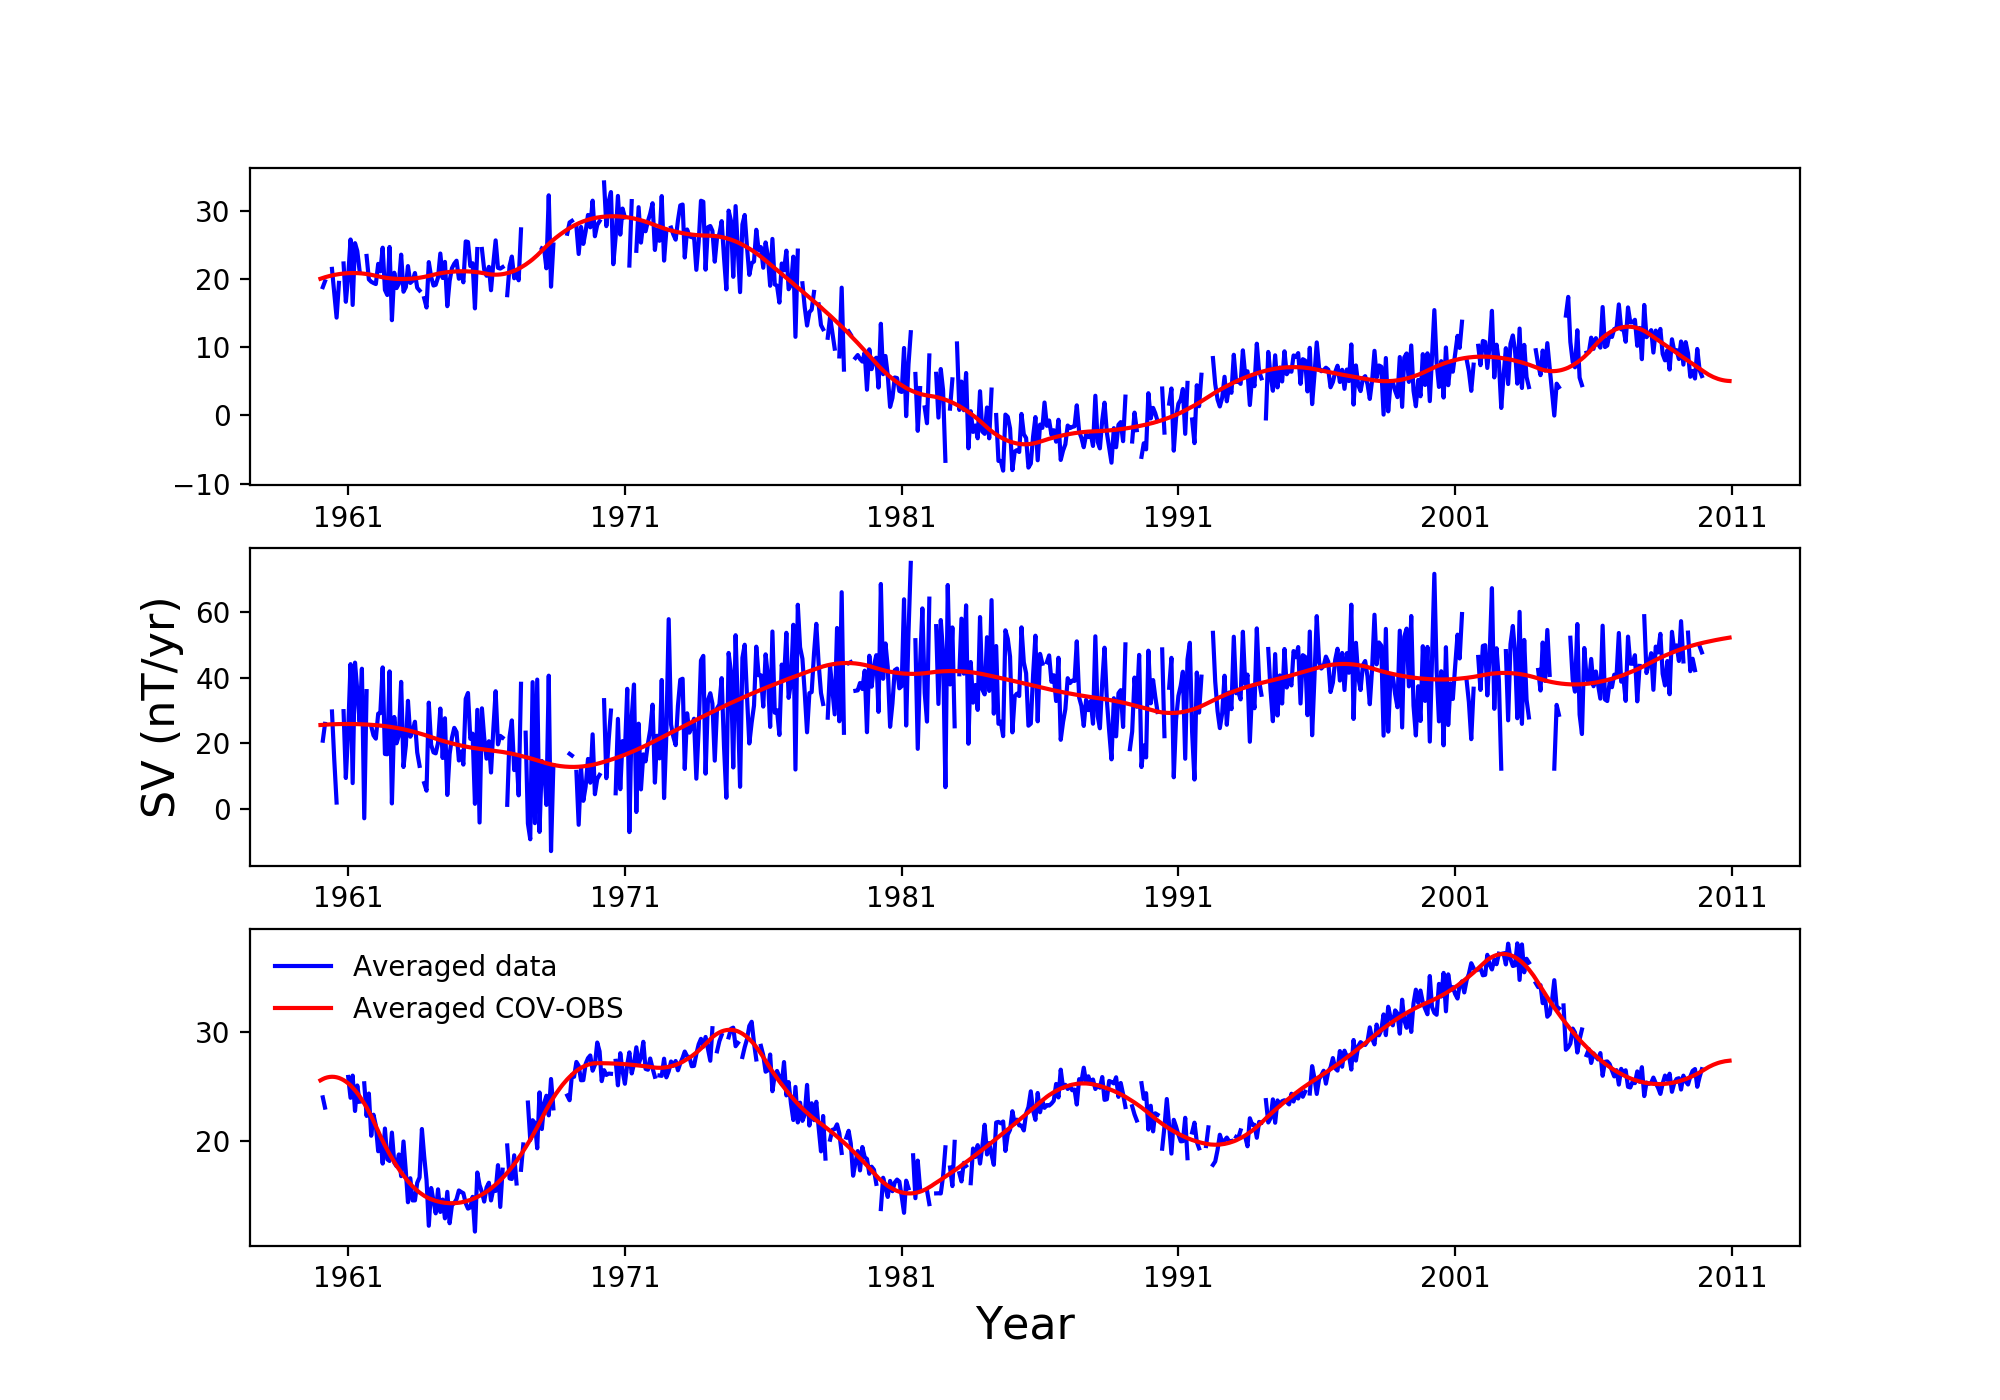

In [22]:
plt.figure(figsize=(10, 7))
plt.subplot(3,1,1)
plt.plot(dates, mean_X, 'b')
plt.plot(dates, np.mean(model_X, axis=1), 'r')
plt.subplot(3,1,2)
plt.plot(dates, mean_Y, 'b')
plt.plot(dates, np.mean(model_Y, axis=1), 'r')
plt.ylabel('SV (nT/yr)', fontsize=16)
plt.subplot(3,1,3)
plt.plot(dates, mean_Z, 'b', label='Averaged data')
plt.plot(dates, np.mean(model_Z, axis=1), 'r', label='Averaged COV-OBS')
plt.xlabel('Year',  fontsize=16)
plt.legend(loc='best', fontsize=10, frameon=False)

## Data selection using the ap index

In [23]:
# Select an observatory
observatory = 'CLF'
data_file = observatory + '.csv'
hourly_data = inputoutput.read_csv_data(
    fname=os.path.join(download_dir + 'hourly/', data_file),
    data_type='mf')
# Correct documented baseline changes
misc.correct_baseline_change(observatory=observatory,
                      field_data=hourly_data,
                      jump_data=baseline_data)
# Apply an Ap criterion to discard noisy data
hourly_data_ap = svtools.apply_Ap_threshold(obs_data=hourly_data, Ap_file='/Users/gracecox/Dropbox/DataDownloads/Kp_Ap/ap_hourly.csv',
                               threshold=7.0)
# Resample to monthly means
resampled_field_data = svtools.data_resampling(hourly_data, sampling='MS', average_date=True)
resampled_field_data_ap = svtools.data_resampling(hourly_data_ap, sampling='MS', average_date=True)
# Calculate SV from monthly field means
sv_data = svtools.calculate_sv(resampled_field_data,
                               mean_spacing=1)
sv_data_ap = svtools.calculate_sv(resampled_field_data_ap,
                               mean_spacing=1)

    observatory  jump_year  x_jump  y_jump  z_jump
115         CLF 1936-01-01    -387     -96     278
116         CLF 1957-01-01      35      -4      72
117         CLF 1968-01-01      -2     -18      11
118         CLF 1983-01-01       0      -9       1
Field jump of unknown magnitude:  1983-01-01 00:00:00


/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/pandas/tseries/index.py:817: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


Calculate the percentage of data remaining after applying the threshold

In [24]:
hourly_data_ap.X.count()/hourly_data.X.count() * 100

52.681426168638076

Compare the hourly magnetic field data before and after appyling the ap threshold

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


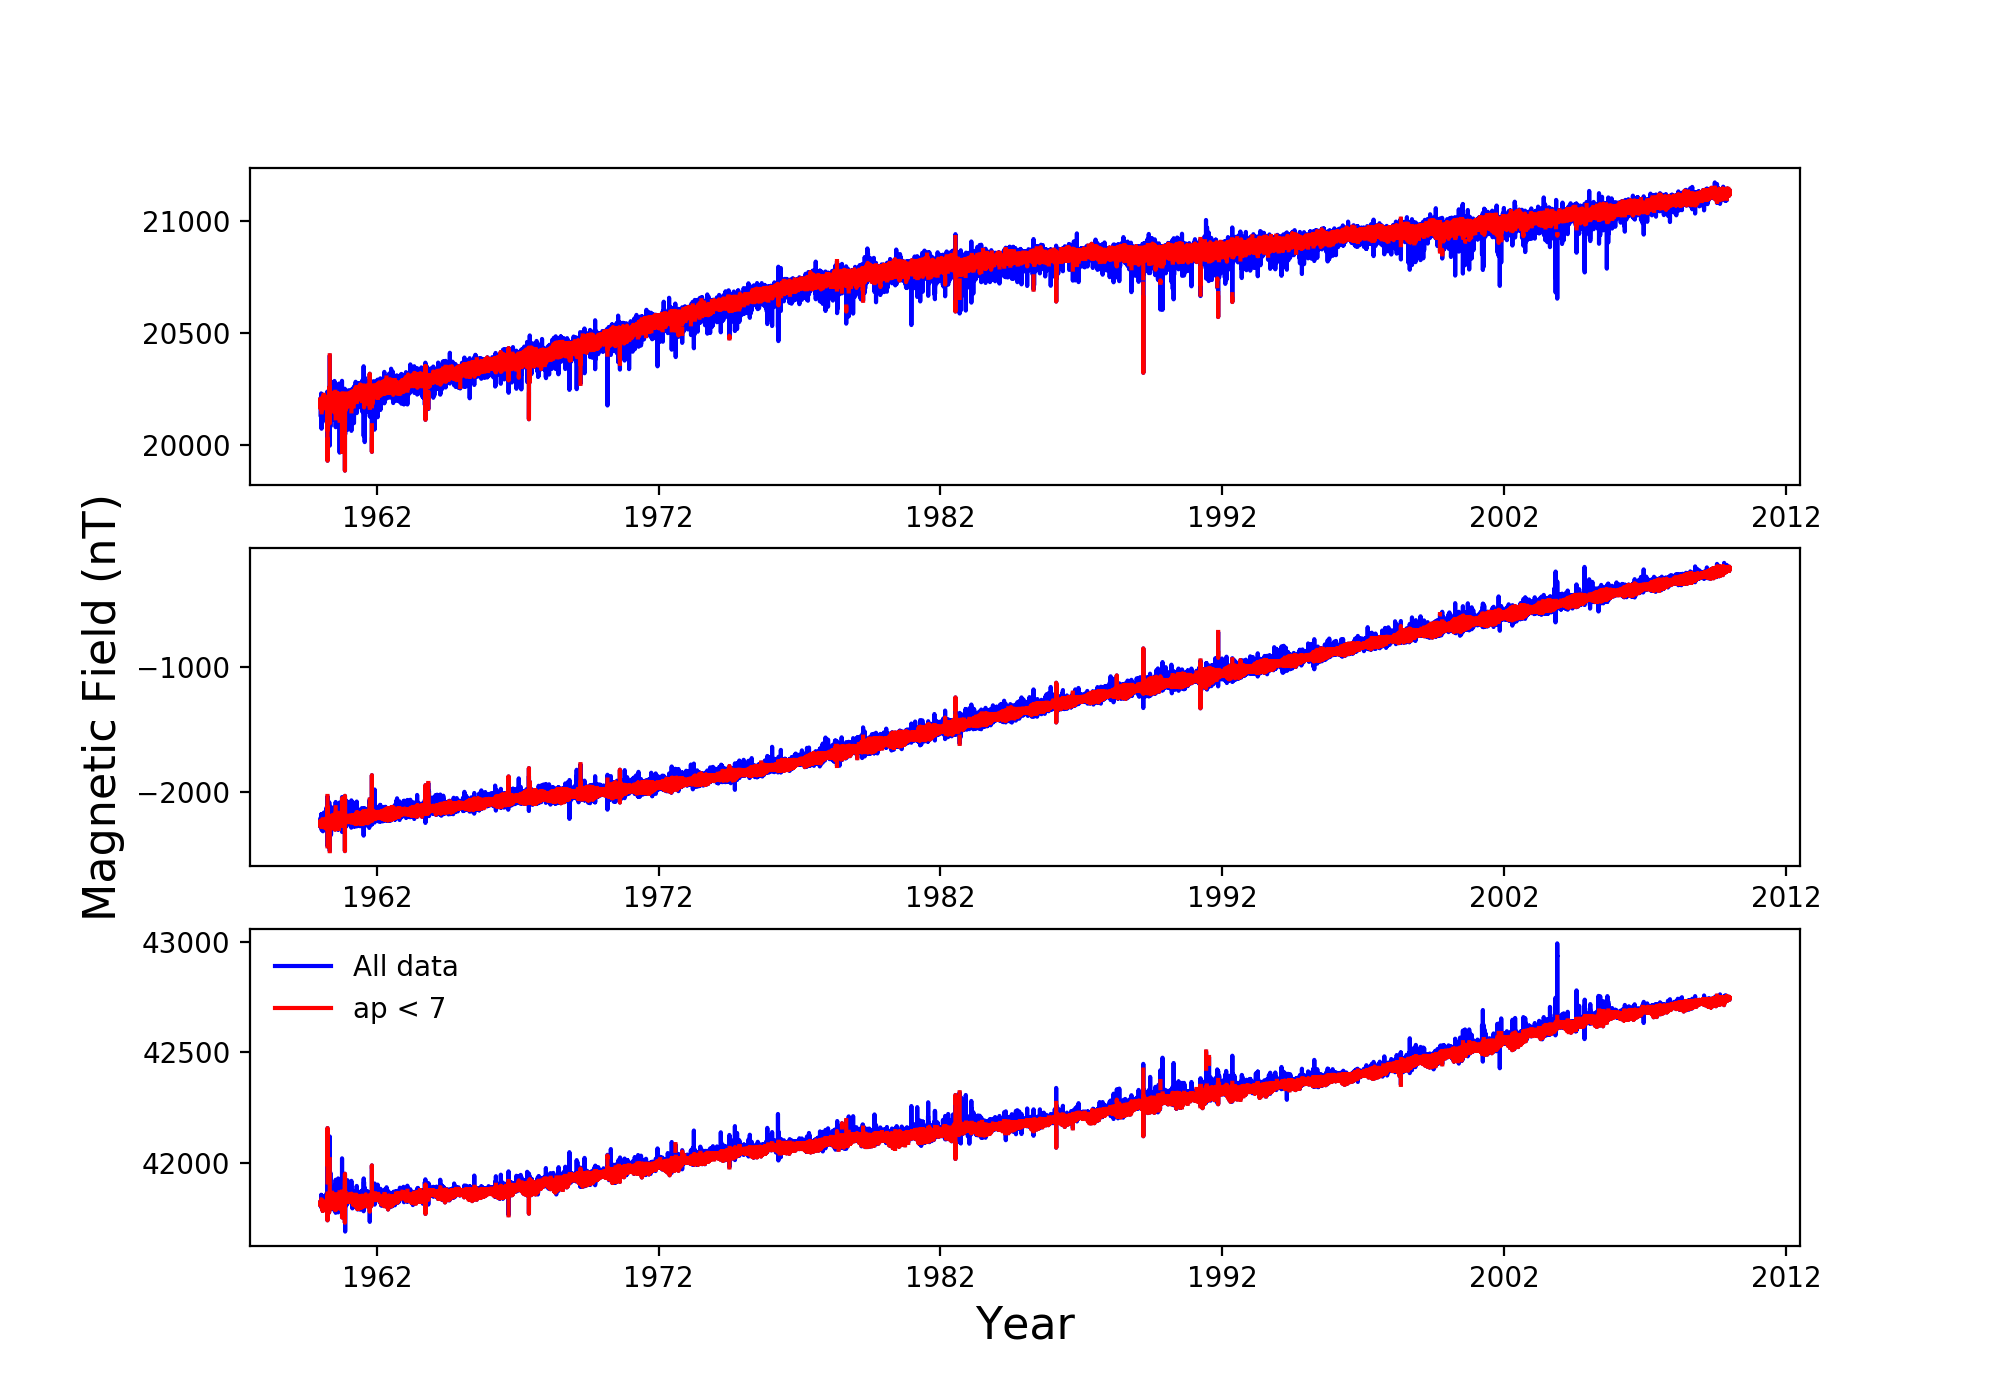

In [25]:
plt.figure(figsize=(10, 7))
plt.subplot(3, 1, 1)
plt.plot(hourly_data.date, hourly_data.X, 'b')
plt.plot(hourly_data.date, hourly_data_ap.X, 'r')
plt.subplot(3, 1, 2)
plt.plot(hourly_data.date, hourly_data.Y, 'b')
plt.plot(hourly_data.date, hourly_data_ap.Y, 'r')
plt.ylabel('Magnetic Field (nT)', fontsize=16)
plt.subplot(3, 1, 3)
plt.plot(hourly_data.date, hourly_data.Z, 'b', label='All data')
plt.plot(hourly_data.date, hourly_data_ap.Z, 'r', label='ap < 7')
plt.xlabel('Year', fontsize=16)
plt.legend(frameon=False)

Compare the SV obtained when calculated using all hourly data and hourly the ap threshold applied

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


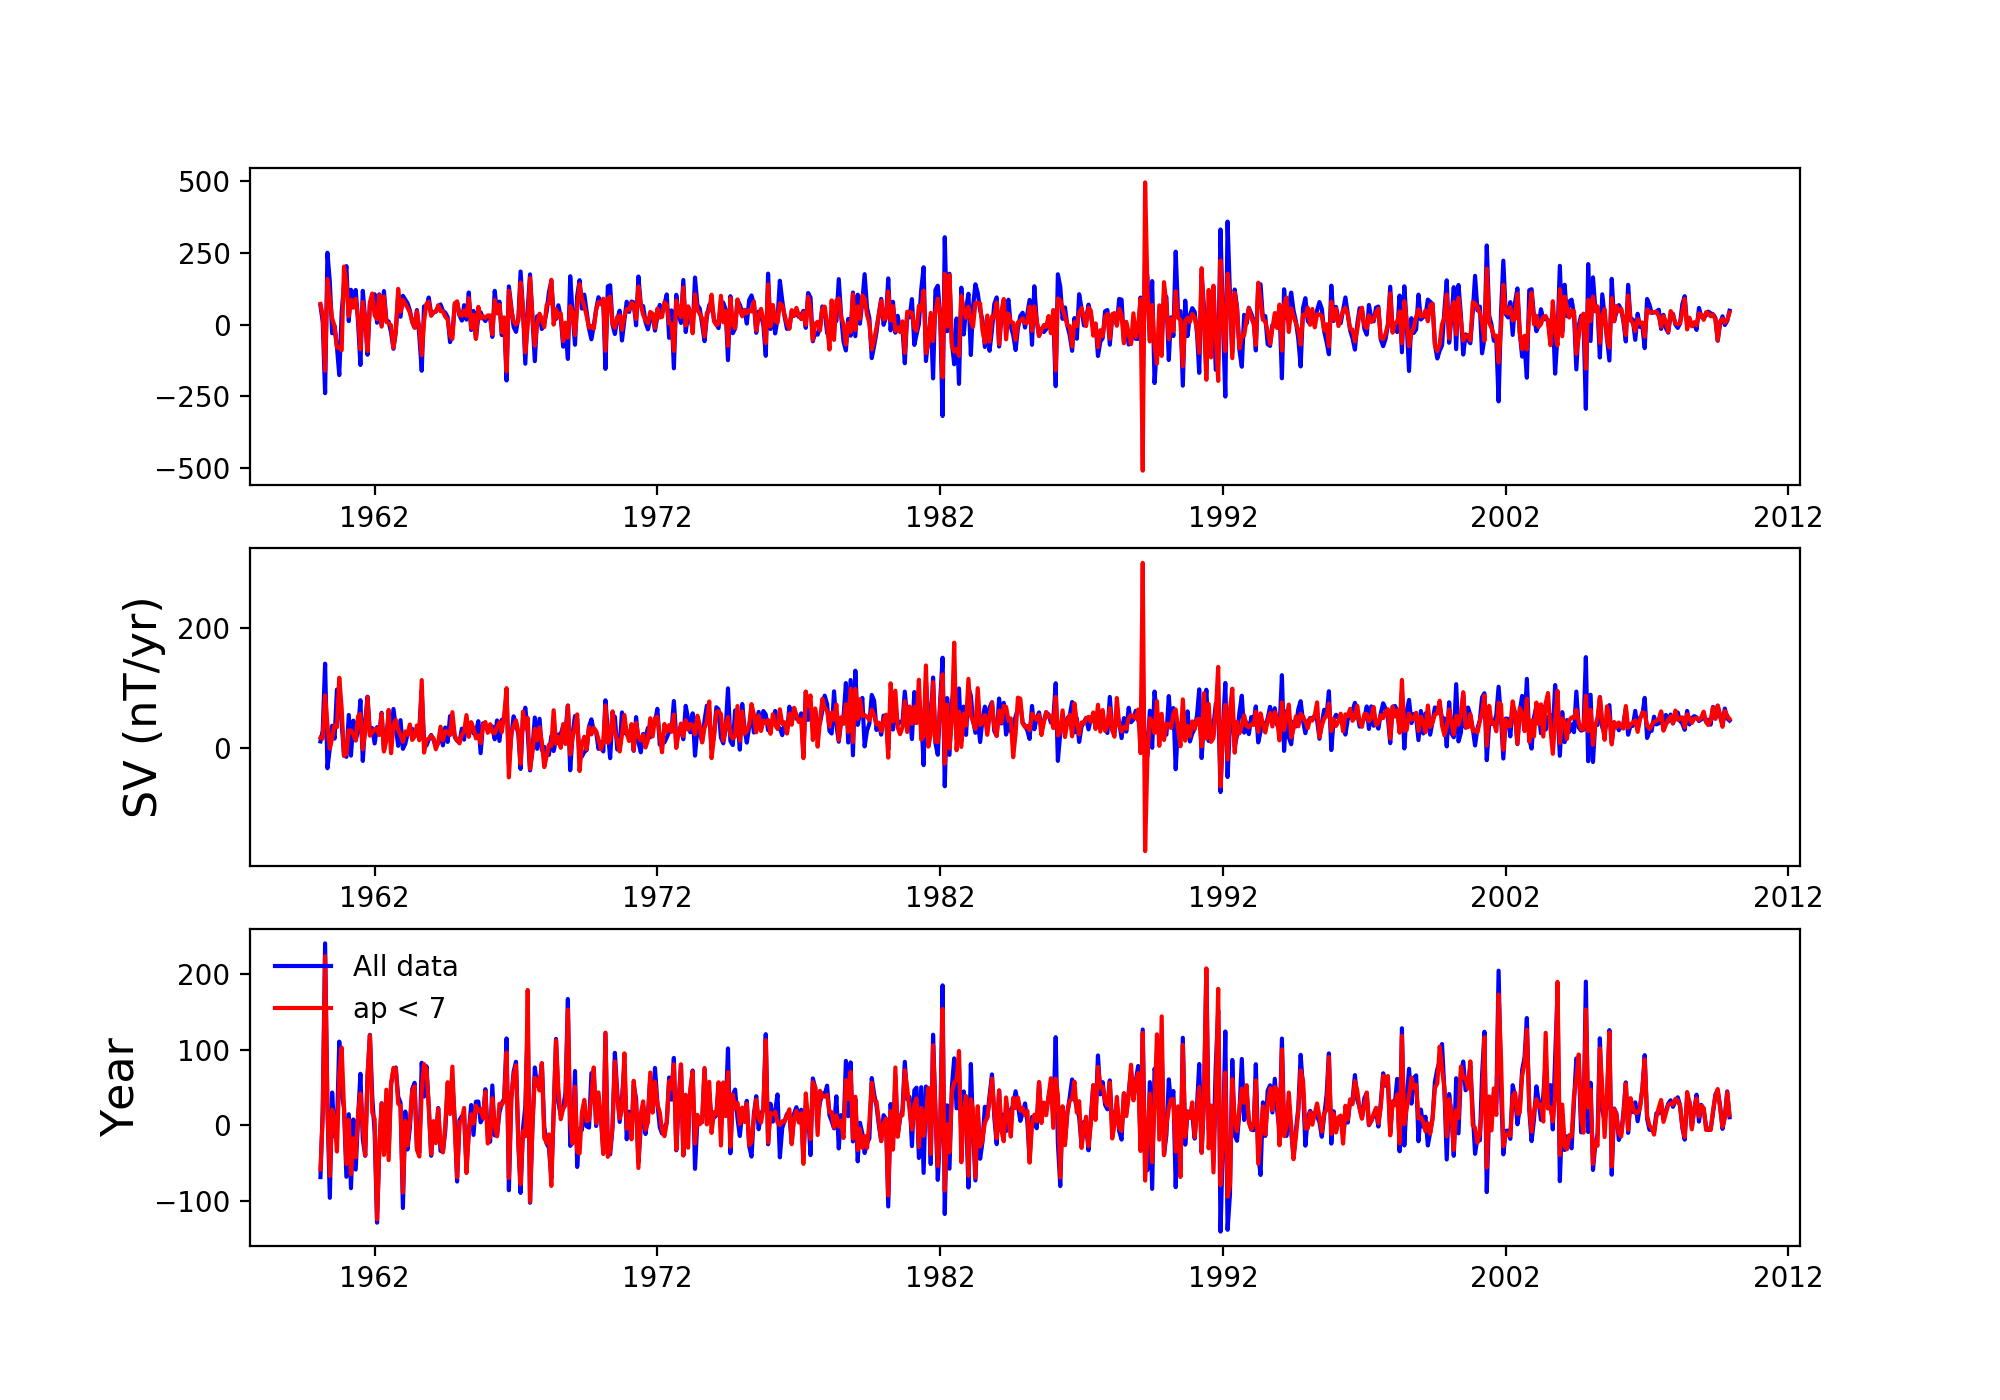

In [26]:
plt.figure(figsize=(10, 7))
plt.subplot(3, 1, 1)
plt.plot(sv_data.date, sv_data.dx, 'b')
plt.plot(sv_data_ap.date, sv_data_ap.dx, 'r')
plt.subplot(3, 1, 2)
plt.plot(sv_data.date, sv_data.dy, 'b')
plt.plot(sv_data_ap.date, sv_data_ap.dy, 'r')
plt.ylabel('SV (nT/yr)', fontsize=16)
plt.subplot(3, 1, 3)
plt.plot(sv_data.date, sv_data.dz, 'b', label='All data')
plt.plot(sv_data.date, sv_data_ap.dz, 'r', label = 'ap < 7')
plt.ylabel('Year', fontsize=16)
plt.legend(frameon=False)